C:\Temp\ipykernel_15276\2290651881.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


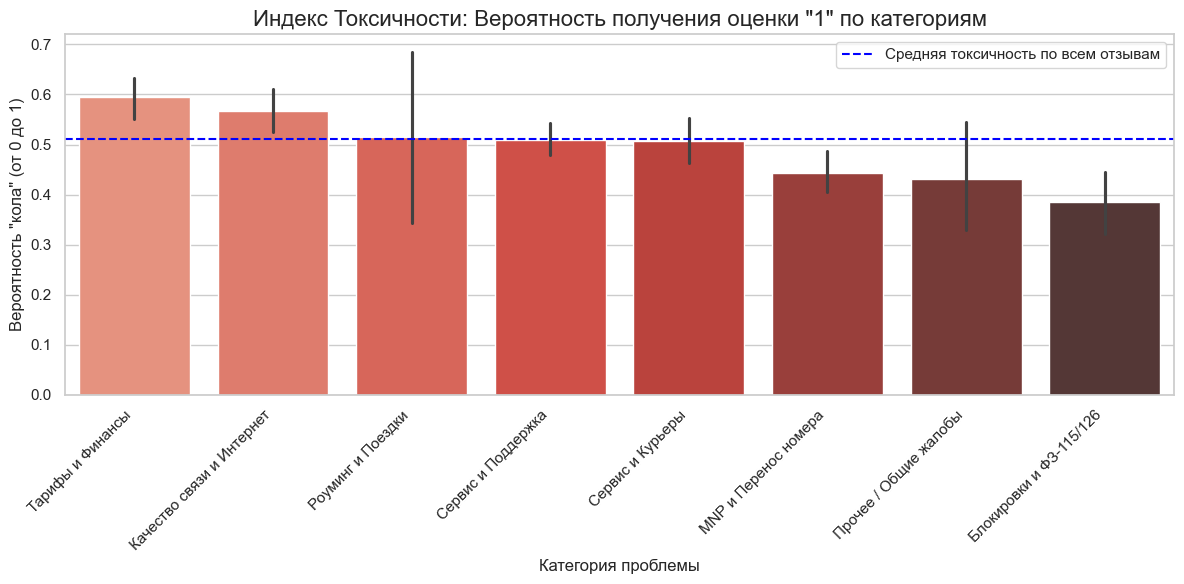

C:\Temp\ipykernel_15276\2290651881.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


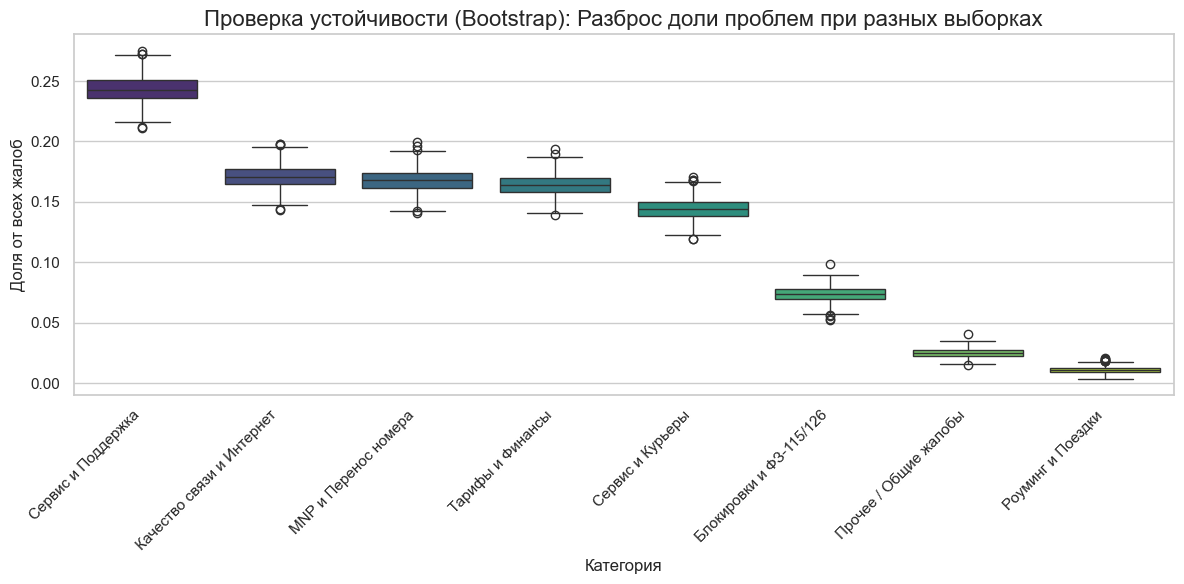

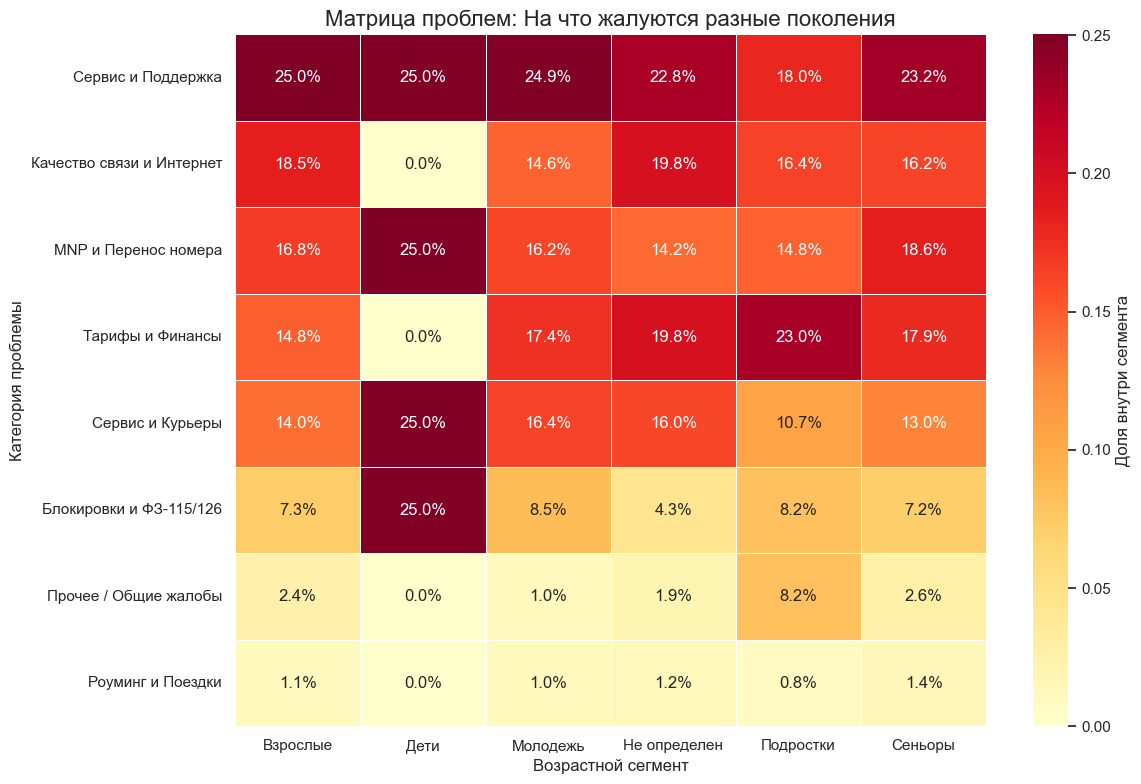

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

# --- НАСТРОЙКИ ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Загрузка данных
file_path = 'negative_t_mobile_reviews_categorized.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите файл.")
    exit()

# 2. Препроцессинг (Разбиваем категории)
def clean_categories(cat):
    if pd.isna(cat): return []
    # Удаляем лишние символы и разбиваем по запятой
    return [x.strip() for x in str(cat).replace('\n', '').replace('\r', '').split(',') if len(x.strip()) > 0]

df['cats_list'] = df['auto_category'].apply(clean_categories)
df_exploded = df.explode('cats_list')
df_exploded = df_exploded.dropna(subset=['cats_list'])

# Отфильтруем редкие категории (оставим топ-10 для чистоты графиков)
top_10_cats = df_exploded['cats_list'].value_counts().nlargest(10).index.tolist()
df_top = df_exploded[df_exploded['cats_list'].isin(top_10_cats)].copy()

# ==============================================================================
# ГРАФИК 1: АНАЛИЗ ТОКСИЧНОСТИ (ДЛЯ ХИ-КВАДРАТ)
# Гипотеза: Есть категории, которые "убивают" лояльность (дают 1 балл чаще других)
# ==============================================================================

# Создаем флаг "Фатальная оценка" (Оценка = 1)
df_top['is_fatal'] = df_top['review_mark'].apply(lambda x: 1 if x == 1 else 0)

plt.figure(figsize=(12, 6))
# Строим барплот, где высота столбца = среднее значение is_fatal (то есть % единиц)
# Черная черточка сверху - это доверительный интервал (CI 95%) от Seaborn
ax1 = sns.barplot(
    data=df_top,
    x='cats_list',
    y='is_fatal',
    palette='Reds_d',
    order=df_top.groupby('cats_list')['is_fatal'].mean().sort_values(ascending=False).index
)

plt.title('Индекс Токсичности: Вероятность получения оценки "1" по категориям', fontsize=16)
plt.ylabel('Вероятность "кола" (от 0 до 1)', fontsize=12)
plt.xlabel('Категория проблемы', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=df_top['is_fatal'].mean(), color='blue', linestyle='--', label='Средняя токсичность по всем отзывам')
plt.legend()
plt.tight_layout()
plt.show()


# ==============================================================================
# ГРАФИК 2: БУТСТРЕП АНАЛИЗ (BOXPLOT)
# Гипотеза: Топ проблем устойчив и не зависит от случайности выборки
# ==============================================================================

n_iterations = 500
bootstrap_data = []

# Запускаем симуляцию
for i in range(n_iterations):
    # Берем случайную подвыборку
    sample = resample(df_top, n_samples=int(len(df_top)*0.5), random_state=i) # 50% выборки
    # Считаем доли категорий в этой подвыборке
    counts = sample['cats_list'].value_counts(normalize=True)

    for cat in top_10_cats:
        bootstrap_data.append({
            'Категория': cat,
            'Доля обращений': counts.get(cat, 0)
        })

df_boot = pd.DataFrame(bootstrap_data)

plt.figure(figsize=(12, 6))
# Boxplot показывает разброс значений при 500 симуляциях
sns.boxplot(
    data=df_boot,
    x='Категория',
    y='Доля обращений',
    palette='viridis',
    order=df_boot.groupby('Категория')['Доля обращений'].median().sort_values(ascending=False).index
)

plt.title('Проверка устойчивости (Bootstrap): Разброс доли проблем при разных выборках', fontsize=16)
plt.ylabel('Доля от всех жалоб', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# ==============================================================================
# ГРАФИК 3: ТЕПЛОВАЯ КАРТА СЕГМЕНТОВ (HEATMAP)
# Гипотеза: Разные возраста жалуются на разное
# ==============================================================================

plt.figure(figsize=(12, 8))

# Строим кросс-таблицу: Категории vs Возрастные сегменты
# normalize='columns' означает, что сумма по столбцу (сегменту) будет 100%
pivot_table = pd.crosstab(
    df_top['cats_list'],
    df_top['age_segment'],
    normalize='columns'
)

# Сортируем для красоты
pivot_table = pivot_table.sort_values(by=pivot_table.columns[0], ascending=False)

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1%",
    cmap="YlOrRd",
    linewidths=.5,
    cbar_kws={'label': 'Доля внутри сегмента'}
)

plt.title('Матрица проблем: На что жалуются разные поколения', fontsize=16)
plt.ylabel('Категория проблемы', fontsize=12)
plt.xlabel('Возрастной сегмент', fontsize=12)
plt.tight_layout()
plt.show()

Сильные проблемы в общем, поэтому все жалуются на поддержку при любой проблеме, стоит дать больше свободы операторам, по типу выдавать бонусы.

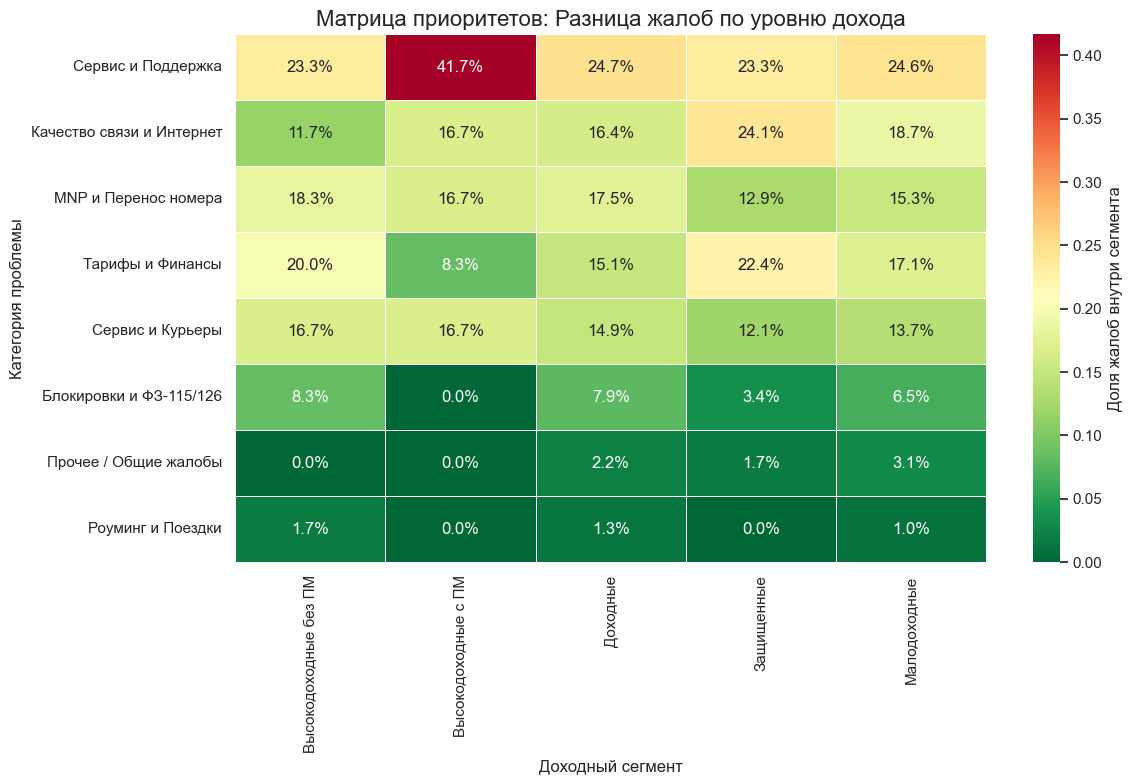

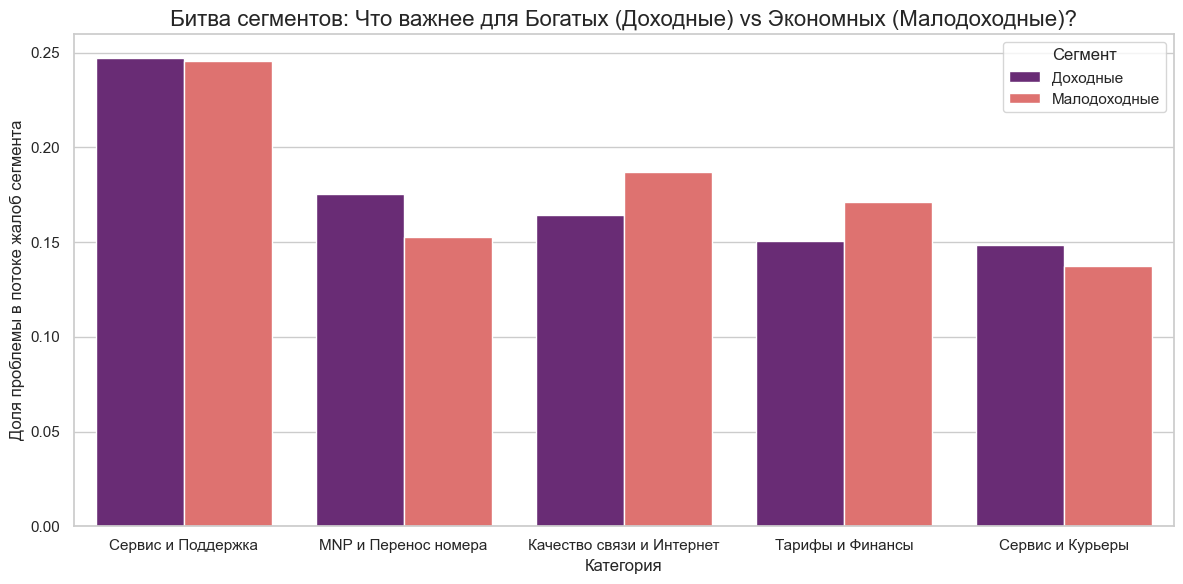

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Загрузка данных
file_path = 'negative_t_mobile_reviews_categorized.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. Очистка данных
# Удаляем пустые сегменты (если вдруг есть)
df = df.dropna(subset=['segment_name'])

# Функция очистки категорий
def clean_categories(cat):
    if pd.isna(cat): return []
    return [x.strip() for x in str(cat).replace('\n', '').replace('\r', '').split(',') if len(x.strip()) > 0]

df['cats_list'] = df['auto_category'].apply(clean_categories)
df_exploded = df.explode('cats_list')
df_exploded = df_exploded.dropna(subset=['cats_list'])

# Оставляем только топ-12 категорий для чистоты графиков
top_cats = df_exploded['cats_list'].value_counts().nlargest(12).index.tolist()
df_filtered = df_exploded[df_exploded['cats_list'].isin(top_cats)]

# ==============================================================================
# ГРАФИК 1: ТЕПЛОВАЯ КАРТА (HEATMAP)
# Вопрос: Что болит у "Доходных" vs "Малодоходных"?
# ==============================================================================

plt.figure(figsize=(12, 8))

# Строим таблицу сопряженности (Crosstab)
# normalize='columns' -> Сумма по каждому сегменту = 100%
pivot_income = pd.crosstab(
    df_filtered['cats_list'],
    df_filtered['segment_name'],
    normalize='columns'
)

# Сортируем категории по общей популярности
pivot_income = pivot_income.loc[top_cats]

sns.heatmap(
    pivot_income,
    annot=True,
    fmt=".1%",
    cmap="RdYlGn_r", # От зеленого (мало жалоб) к красному (много)
    linewidths=.5,
    cbar_kws={'label': 'Доля жалоб внутри сегмента'}
)

plt.title('Матрица приоритетов: Разница жалоб по уровню дохода', fontsize=16)
plt.ylabel('Категория проблемы', fontsize=12)
plt.xlabel('Доходный сегмент', fontsize=12)
plt.tight_layout()
plt.show()

# ==============================================================================
# ГРАФИК 2: ГЛУБОКИЙ АНАЛИЗ ТОП-5 ПРОБЛЕМ
# Вопрос: Есть ли разрыв восприятия в ключевых проблемах?
# ==============================================================================

top_5_cats = top_cats[:5]
df_top5 = df_filtered[df_filtered['cats_list'].isin(top_5_cats)]

# Считаем доли внутри групп
grouped_data = df_top5.groupby(['cats_list', 'segment_name']).size().reset_index(name='count')
# Нормируем: переводим абсолютные числа в проценты внутри категории, чтобы сравнить вклад сегментов
# (Или лучше показать долю проблемы внутри сегмента, как на хитмапе, но в виде баров для наглядности сравнения)

# Вариант: Сравнение распределения проблем для двух полярных групп (если они есть)
target_segments = ['Доходные', 'Малодоходные'] # Проверьте, есть ли точно такие названия в CSV
if all(seg in df['segment_name'].unique() for seg in target_segments):
    df_target = df_filtered[df_filtered['segment_name'].isin(target_segments)]

    # Считаем % проблем внутри каждого сегмента
    counts = (df_target.groupby(['segment_name'])['cats_list']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .reset_index())

    # Оставляем только топ-5 проблем для графика
    counts = counts[counts['cats_list'].isin(top_5_cats)]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=counts,
        x='cats_list',
        y='percentage',
        hue='segment_name',
        palette='magma'
    )

    plt.title('Битва сегментов: Что важнее для Богатых (Доходные) vs Экономных (Малодоходные)?', fontsize=16)
    plt.ylabel('Доля проблемы в потоке жалоб сегмента', fontsize=12)
    plt.xlabel('Категория', fontsize=12)
    plt.legend(title='Сегмент')
    plt.tight_layout()
    plt.show()
else:
    print(f"Внимание: В данных нет сегментов {target_segments}. Доступные сегменты:", df['segment_name'].unique())
    # Если конкретных нет, строим просто общий барплот по всем сегментам
    plt.figure(figsize=(14, 6))
    sns.countplot(data=df_filtered, x='cats_list', hue='segment_name', palette='viridis')
    plt.xticks(rotation=45)
    plt.title('Абсолютное количество жалоб по сегментам', fontsize=16)
    plt.show()

Файл загружен.
Всего отзывов: 53889
Отзывов про Т-Мобайл: 1028


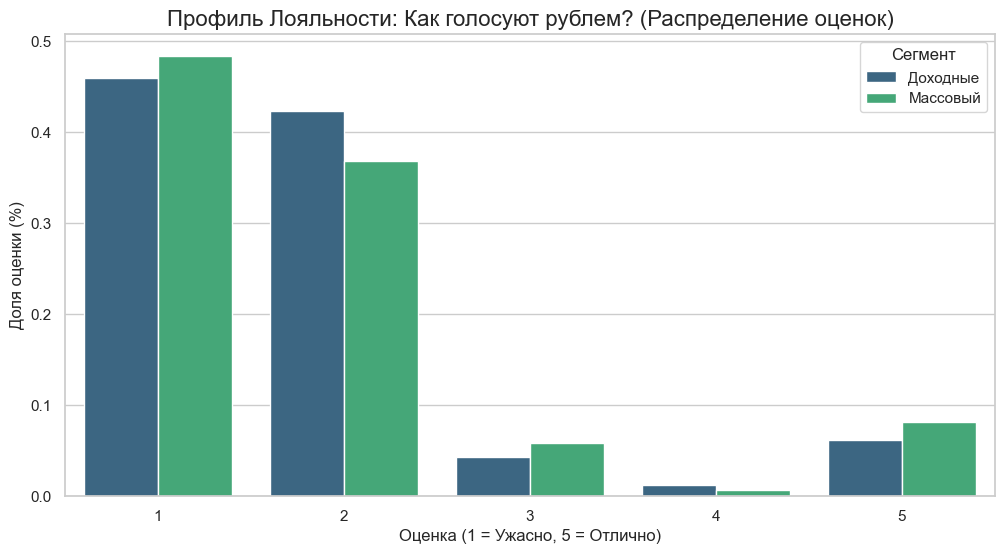

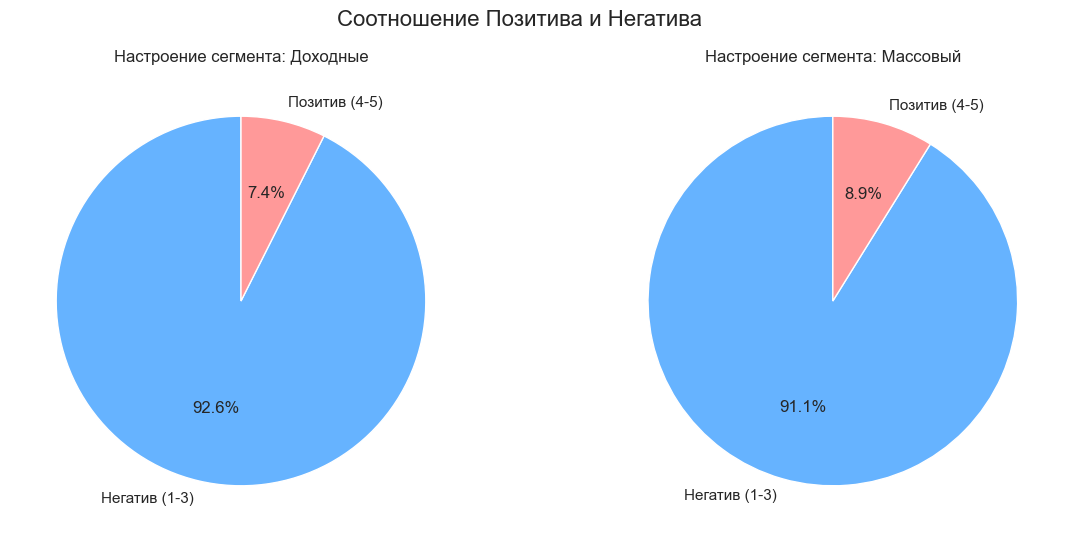

C:\Temp\ipykernel_15276\247613053.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


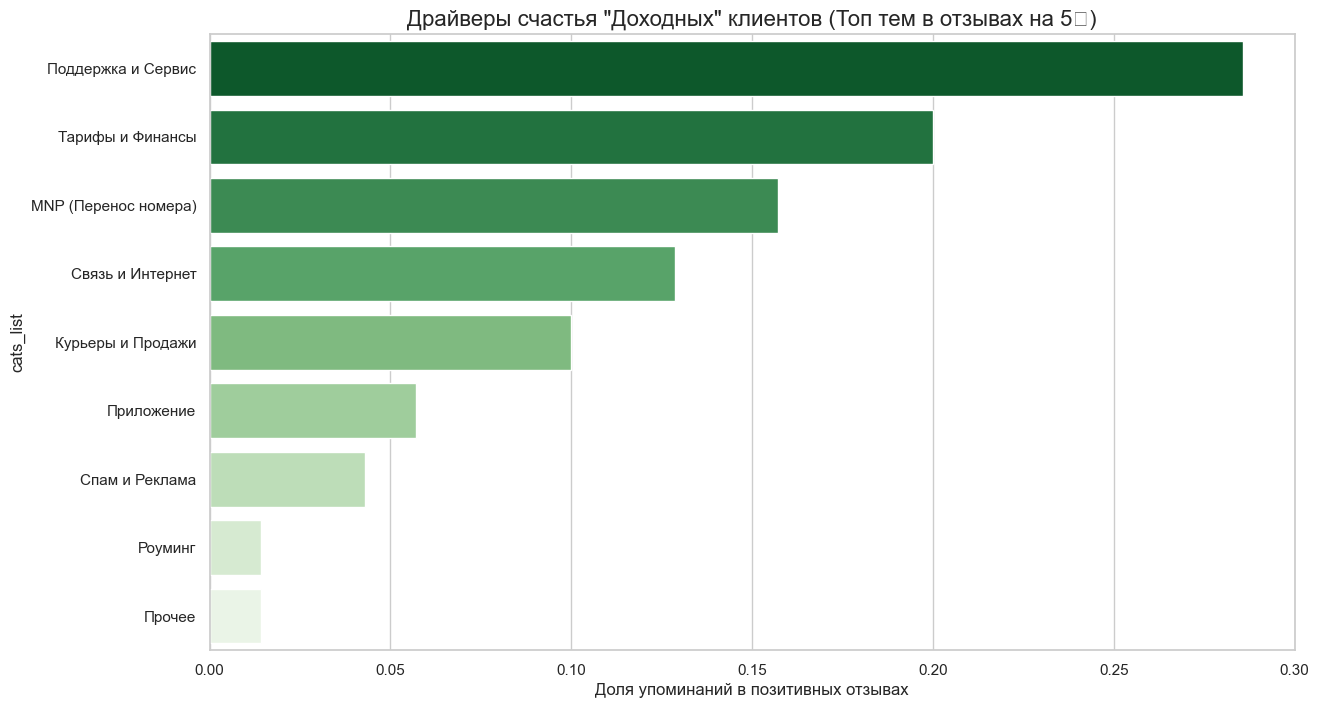


--- ИТОГОВАЯ СТАТИСТИКА ---
Средняя оценка 'Доходные': 1.79
Средняя оценка 'Массовый': 1.83
ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.


In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 1. Загрузка данных
file_path = 'cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print("Файл загружен.")
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. Фильтрация данных
# Нам нужны только отзывы про Мобайл
df_mobile = df[df['company'] == 'Мобайл'].copy()

print(f"Всего отзывов: {len(df)}")
print(f"Отзывов про Т-Мобайл: {len(df_mobile)}")

# 3. Авто-категоризация (Ключевые слова)
# Воссоздаем логику классификации, чтобы понять темы
keywords = {
    'Связь и Интернет': ['связ', 'интернет', 'сеть', 'ловит', 'lte', '4g', '3g', 'скорость', 'вышка', 'палочк'],
    'Тарифы и Финансы': ['тариф', 'цен', 'плат', 'списал', 'деньг', 'руб', 'дорог', 'подписк', 'услуг'],
    'Поддержка и Сервис': ['поддержк', 'чат', 'оператор', 'бот', 'отвечает', 'хам', 'ждал', 'дозвон'],
    'MNP (Перенос номера)': ['перенос', 'mnp', 'номер', 'переш', 'заявк', 'отказ'],
    'Курьеры и Продажи': ['курьер', 'представител', 'доставк', 'встреч', 'навязал', 'симк'],
    'Роуминг': ['роуминг', 'границ', 'поездк', 'зарубеж'],
    'Спам и Реклама': ['спам', 'звонк', 'реклам', 'смс'],
    'Приложение': ['приложен', 'app', 'глючит', 'вылетает', 'вход', 'баг']
}

def classify_text(text):
    text = str(text).lower()
    found_cats = []
    for cat, words in keywords.items():
        if any(w in text for w in words):
            found_cats.append(cat)
    return found_cats if found_cats else ['Прочее']

# Применяем классификацию
df_mobile['cats_list'] = df_mobile['review_text'].apply(classify_text)
df_exploded = df_mobile.explode('cats_list')

# 4. Анализ Сегментов
# Выделяем "Доходные" и всех остальных (Массовый сегмент)
target_segment = 'Доходные'
# Проверяем, есть ли такой сегмент, если нет - берем топ-2 популярных
if target_segment not in df_mobile['segment_name'].unique():
    print(f"Сегмент '{target_segment}' не найден. Используем доступные.")
    top_segments = df_mobile['segment_name'].value_counts().nlargest(2).index.tolist()
    seg1, seg2 = top_segments[0], top_segments[1]
else:
    seg1 = target_segment
    # Все остальные объединяем в "Массовый" для сравнения
    df_mobile['segment_group'] = df_mobile['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')
    seg1 = 'Доходные'
    seg2 = 'Массовый'
    # Обновляем exploded датафрейм тоже
    df_exploded['segment_group'] = df_exploded['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')

# ==============================================================================
# ГРАФИК 1: Распределение Оценок (NPS proxy)
# Ставят ли богатые пятерки?
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем % каждой оценки внутри группы
rating_dist = (df_mobile.groupby(['segment_group'])['review_mark']
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

sns.barplot(
    data=rating_dist,
    x='review_mark',
    y='percentage',
    hue='segment_group',
    palette='viridis'
)

plt.title('Профиль Лояльности: Как голосуют рублем? (Распределение оценок)', fontsize=16)
plt.ylabel('Доля оценки (%)', fontsize=12)
plt.xlabel('Оценка (1 = Ужасно, 5 = Отлично)', fontsize=12)
plt.legend(title='Сегмент')
plt.show()

# ==============================================================================
# ГРАФИК 2: Доля Негатива (Pie Charts)
# Сравниваем % плохих отзывов (1-3) vs Хороших (4-5)
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, segment in enumerate([seg1, seg2]):
    subset = df_mobile[df_mobile['segment_group'] == segment]
    # Негатив: 1-3, Позитив: 4-5
    sentiment = subset['review_mark'].apply(lambda x: 'Позитив (4-5)' if x >= 4 else 'Негатив (1-3)').value_counts()

    axes[i].pie(sentiment, labels=sentiment.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
    axes[i].set_title(f'Настроение сегмента: {segment}')

plt.suptitle('Соотношение Позитива и Негатива', fontsize=16)
plt.show()

# ==============================================================================
# ГРАФИК 3: О чем говорят ПОЗИТИВНЫЕ отзывы?
# Что радует богатых?
# ==============================================================================
positive_reviews = df_exploded[df_exploded['review_mark'] >= 5]
if not positive_reviews.empty:
    plt.figure(figsize=(14, 8))

    # Считаем топ тем в позитиве для Доходных
    pos_counts = (positive_reviews[positive_reviews['segment_group'] == 'Доходные']['cats_list']
                  .value_counts(normalize=True)
                  .head(10))

    sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
    plt.title('Драйверы счастья "Доходных" клиентов (Топ тем в отзывах на 5★)', fontsize=16)
    plt.xlabel('Доля упоминаний в позитивных отзывах', fontsize=12)
    plt.show()

# ==============================================================================
# ВЫВОД СТАТИСТИКИ
# ==============================================================================
avg_mark_high = df_mobile[df_mobile['segment_group'] == 'Доходные']['review_mark'].mean()
avg_mark_mass = df_mobile[df_mobile['segment_group'] == 'Массовый']['review_mark'].mean()

print(f"\n--- ИТОГОВАЯ СТАТИСТИКА ---")
print(f"Средняя оценка 'Доходные': {avg_mark_high:.2f}")
print(f"Средняя оценка 'Массовый': {avg_mark_mass:.2f}")

diff = avg_mark_high - avg_mark_mass
if diff > 0.2:
    print("ВЫВОД: Доходные клиенты заметно лояльнее (+). Им нравится продукт.")
elif diff < -0.2:
    print("ВЫВОД: Доходные клиенты настроены критично (-). Продукт не соответствует их ожиданиям.")
else:
    print("ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.")

In [51]:
df["company"].unique()

array(['Банк', 'SME', 'Инвест', 'Страховая', 'Плашки Media', 'Мобайл',
       'ТРабота'], dtype=object)

Данные загружены.


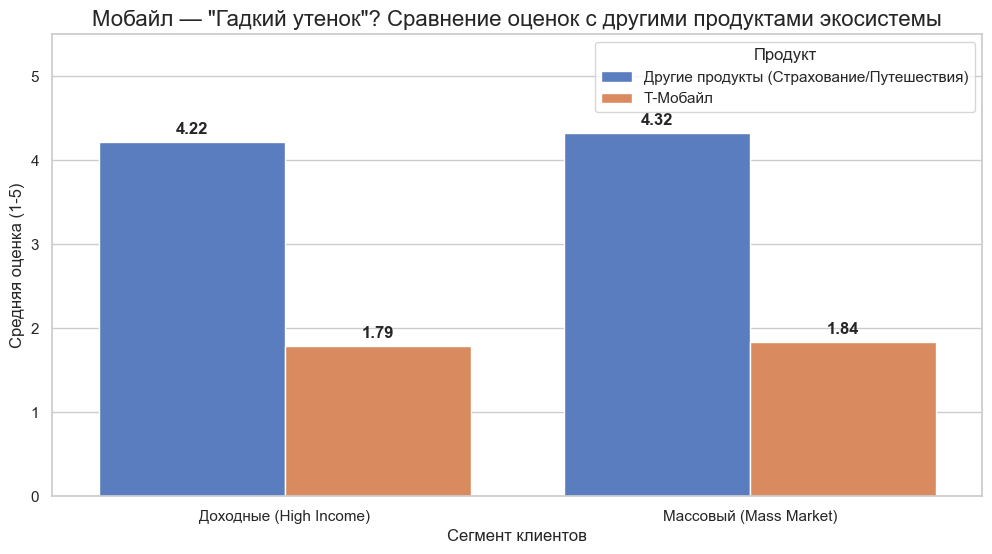

C:\Temp\ipykernel_15276\1423770007.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)


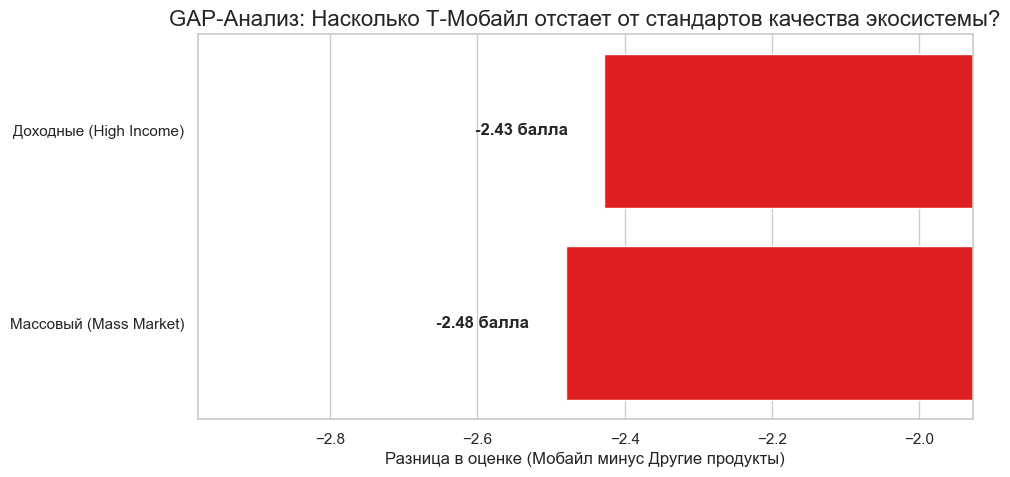


--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---
Разрыв для Доходных: -2.43
Разрыв для Массовых: -2.48

🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:
Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.
Они привыкли к идеальному сервису, и Мобайл их разочаровывает.


In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Загрузка
try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл cleaned.csv не найден.")
    exit()

# 2. Подготовка данных
# Нам нужно сравнить "Мобайл" с "Небанковскими продуктами"
# Исключаем 'Банк', чтобы сравнить именно экосистемные сервисы (Мобайл, Страхование, Путешествия и т.д.)
# Если вы хотите включить Банк в сравнение, закомментируйте следующую строку.
df_ecosystem = df[df['company'] != 'Банк'].copy()
df["company"].unique()
# Создаем флаг продукта
df_ecosystem['product_type'] = df_ecosystem['company'].apply(
    lambda x: 'Т-Мобайл' if x == 'Мобайл' else 'Другие продукты (Страхование/Путешествия)'
)

# Упрощаем сегменты до "Доходные" и "Массовые"
def simplify_segment(seg):
    if pd.isna(seg): return 'Неизвестно'
    if seg == 'Доходные': return 'Доходные (High Income)'
    return 'Массовый (Mass Market)'

df_ecosystem['segment_group'] = df_ecosystem['segment_name'].apply(simplify_segment)
df_ecosystem = df_ecosystem[df_ecosystem['segment_group'] != 'Неизвестно']

# ==============================================================================
# ГРАФИК 1: СРАВНЕНИЕ СРЕДНИХ ОЦЕНОК
# Гипотеза: Столбцы Мобайла будут ниже, чем столбцы Других продуктов
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем средние оценки
avg_ratings = df_ecosystem.groupby(['segment_group', 'product_type'])['review_mark'].mean().reset_index()

barplot = sns.barplot(
    data=avg_ratings,
    x='segment_group',
    y='review_mark',
    hue='product_type',
    palette='muted'
)

plt.title('Мобайл — "Гадкий утенок"? Сравнение оценок с другими продуктами экосистемы', fontsize=16)
plt.ylabel('Средняя оценка (1-5)', fontsize=12)
plt.xlabel('Сегмент клиентов', fontsize=12)
plt.ylim(0, 5.5)
plt.legend(title='Продукт')

# Добавляем цифры
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(f'{p.get_height():.2f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 9),
                         textcoords = 'offset points',
                         fontweight='bold')
plt.show()

# ==============================================================================
# ГРАФИК 2: GAP ANALYSIS (АНАЛИЗ РАЗРЫВА)
# Насколько Мобайл хуже/лучше других продуктов для каждого сегмента?
# ==============================================================================

# Пивот таблица для расчета разницы
pivot_avg = avg_ratings.pivot(index='segment_group', columns='product_type', values='review_mark')
pivot_avg['Gap'] = pivot_avg['Т-Мобайл'] - pivot_avg['Другие продукты (Страхование/Путешествия)']

plt.figure(figsize=(10, 5))
colors = ['red' if x < 0 else 'green' for x in pivot_avg['Gap']]
gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)

plt.axvline(0, color='black', linewidth=1)
plt.title('GAP-Анализ: Насколько Т-Мобайл отстает от стандартов качества экосистемы?', fontsize=16)
plt.xlabel('Разница в оценке (Мобайл минус Другие продукты)', fontsize=12)
plt.ylabel('')

# Подписи значений
for i, v in enumerate(pivot_avg['Gap']):
    offset = 0.05 if v >= 0 else -0.05
    ha = 'left' if v >= 0 else 'right'
    gap_plot.text(v + offset, i, f"{v:.2f} балла", va='center', ha=ha, fontweight='bold', fontsize=12)

plt.xlim(min(pivot_avg['Gap']) - 0.5, max(pivot_avg['Gap']) + 0.5)
plt.show()

# ==============================================================================
# ВЫВОДЫ В КОНСОЛЬ
# ==============================================================================
print("\n--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---")
gap_high = pivot_avg.loc['Доходные (High Income)', 'Gap']
gap_mass = pivot_avg.loc['Массовый (Mass Market)', 'Gap']

print(f"Разрыв для Доходных: {gap_high:.2f}")
print(f"Разрыв для Массовых: {gap_mass:.2f}")

if gap_high < -0.5:
    print("\n🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:")
    print("Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.")
    print("Они привыкли к идеальному сервису, и Мобайл их разочаровывает.")
elif gap_high < 0:
    print("\n🟠 УМЕРЕННАЯ ПРОБЛЕМА:")
    print("Т-Мобайл оценивают чуть хуже других продуктов, но разрыв не катастрофический.")
else:
    print("\n🟢 ГИПОТЕЗА ОПРОВЕРГНУТА:")
    print("Т-Мобайл оценивают ТАК ЖЕ или ЛУЧШЕ, чем другие продукты экосистемы.")

In [53]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите cleaned.csv")
    exit()
df_model = df[df['company'] != 'Банк'].copy()

df_model = df_model.dropna(subset=['review_mark'])
df_model['score'] = df_model['review_mark'].astype(float)

df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

df_model['segment_name'] = df_model['segment_name'].fillna('Массовый')
df_model['age_segment'] = df_model['age_segment'].fillna('Взрослые')
df_model['gender_cd'] = df_model['gender_cd'].fillna('U')

cols_to_encode = ['segment_name', 'age_segment', 'gender_cd']
X_encoded = pd.get_dummies(df_model[cols_to_encode], drop_first=True)

# Собираем финальную матрицу X
X = pd.concat([df_model[['is_mobile']], X_encoded], axis=1)
y = df_model['is_negative']

print(f"Размер выборки для анализа: {len(df_model)} строк")

print_header("ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)")

formula_ols = "score ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"
formula_logit = "is_negative ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"
model_ols = smf.ols(formula_ols, data=df_model).fit()
beta_mobile = model_ols.params['is_mobile']
p_ols = model_ols.pvalues['is_mobile']
print(model_ols.summary())
model_logit = smf.logit(formula_logit, data=df_model).fit(disp=0)
log_odds_mobile = model_logit.params['is_mobile']
odds_ratio_mobile = np.exp(log_odds_mobile)
p_logit = model_logit.pvalues['is_mobile']
print(model_logit.summary())
results_df = pd.DataFrame({
    'Модель': ['OLS (Влияние на балл)', 'LOGIT (Влияние на риск)'],
    'Ключевая Метрика': ['Коэффициент (Beta)', 'Odds Ratio (Шансы)'],
    'Значение': [f"{beta_mobile:.3f}", f"{odds_ratio_mobile:.3f}"],
    'P-value': [f"{p_ols:.5f}", f"{p_logit:.5f}"],
    'Вердикт (p<0.05)': ['✅ ЗНАЧИМО' if p_ols < 0.05 else '❌ НЕТ', '✅ ЗНАЧИМО' if p_logit < 0.05 else '❌ НЕТ']
})

print(results_df)

print("\nИНТЕРПРЕТАЦИЯ:")
if beta_mobile < 0:
    print(f"1. OLS: Т-Мобайл снижает среднюю оценку на {abs(beta_mobile):.2f} балла.")
if odds_ratio_mobile > 1:
    print(f"2. LOGIT: Т-Мобайл повышает вероятность негатива в {odds_ratio_mobile:.2f} РАЗА.")







Данные загружены.
Размер выборки для анализа: 21223 строк

 ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     477.9
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:48:17   Log-Likelihood:                -33322.
No. Observations:               21223   AIC:                         6.667e+04
Df Residuals:                   21209   BIC:                         6.678e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----


 ШАГ 1: ВИЗУАЛЬНОЕ СРАВНЕНИЕ (BOXPLOT)


C:\Temp\ipykernel_15276\2617097396.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='company', y='review_mark', data=df_nonfin, order=order, palette='Set3')


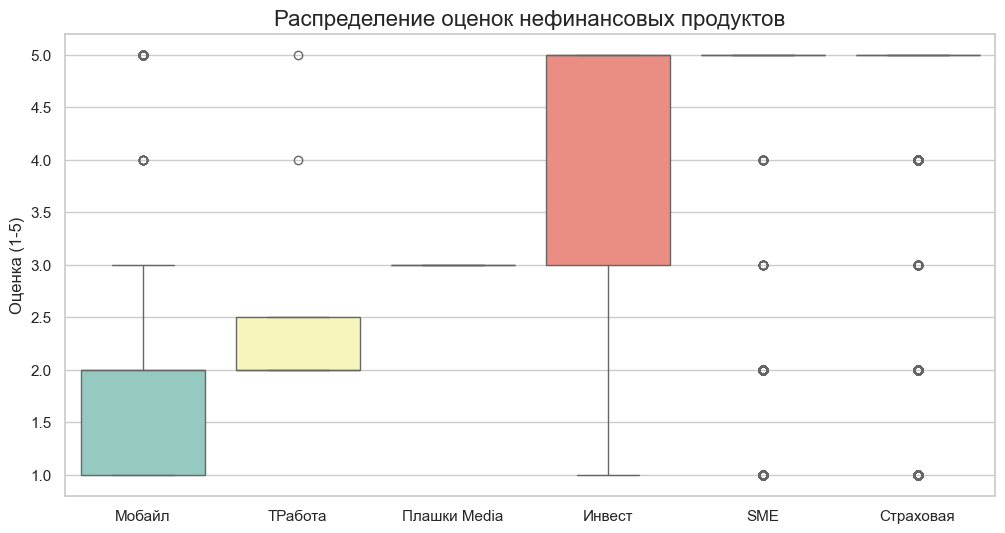


 ШАГ 2: СЕРИЯ ДУЭЛЕЙ (MANN-WHITNEY U TEST)
Гипотеза H1: Оценки 'Мобайл' СТАТИСТИЧЕСКИ НИЖЕ, чем у конкурента.

      Конкурент    Mobile Хуже?        P-value Вероятность проигрыша
0           SME  ✅ ДА (Значимо)   0.000000e+00                 91.8%
1        Инвест  ✅ ДА (Значимо)   0.000000e+00                 85.5%
2     Страховая  ✅ ДА (Значимо)   0.000000e+00                 91.1%
3  Плашки Media  ✅ ДА (Значимо)  1.119352e-171                 89.1%
4       ТРабота  ✅ ДА (Значимо)   5.606216e-03                 73.8%

 ИТОГОВЫЙ ВЕРДИКТ
🏆 'Т-Мобайл' — АБСОЛЮТНЫЙ АУТСАЙДЕР.
Тест Манна-Уитни показал, что Мобайл статистически значимо хуже
КАЖДОГО другого нефинансового продукта в экосистеме.
Это не случайность, это системный провал качества.

[Глобальный тест Краскела-Уоллиса]
Есть ли вообще разница между продуктами? Да (p=0.00000)


In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА
# Исключаем Банк, чтобы сравнить сервисные продукты
df_nonfin = df[df['company'] != 'Банк'].copy()
df_nonfin = df_nonfin.dropna(subset=['review_mark'])

# Список продуктов для сравнения
products = df_nonfin['company'].unique()
target_product = 'Мобайл'

if target_product not in products:
    print(f"Ошибка: Продукт '{target_product}' не найден в данных.")
    exit()

# ==============================================================================
# ВИЗУАЛИЗАЦИЯ (BOXPLOT) - ЧТОБЫ УВИДЕТЬ ГЛАЗАМИ
# ==============================================================================
print_header("ШАГ 1: ВИЗУАЛЬНОЕ СРАВНЕНИЕ (BOXPLOT)")

# Сортируем продукты по медианной оценке (от худшего к лучшему)
order = df_nonfin.groupby('company')['review_mark'].median().sort_values().index

plt.figure(figsize=(12, 6))
sns.boxplot(x='company', y='review_mark', data=df_nonfin, order=order, palette='Set3')
plt.title('Распределение оценок нефинансовых продуктов', fontsize=16)
plt.ylabel('Оценка (1-5)', fontsize=12)
plt.xlabel('')
plt.show()

# ==============================================================================
# СТАТИСТИЧЕСКИЙ ТЕСТ (MANN-WHITNEY U)
# ==============================================================================
print_header("ШАГ 2: СЕРИЯ ДУЭЛЕЙ (MANN-WHITNEY U TEST)")
print(f"Гипотеза H1: Оценки '{target_product}' СТАТИСТИЧЕСКИ НИЖЕ, чем у конкурента.\n")

results = []
mobile_ratings = df_nonfin[df_nonfin['company'] == target_product]['review_mark']

for competitor in products:
    if competitor == target_product:
        continue

    comp_ratings = df_nonfin[df_nonfin['company'] == competitor]['review_mark']

    # Тест Манна-Уитни
    # alternative='less' означает: Проверяем, что медиана Mobile МЕНЬШЕ медианы Competitor
    stat, p_value = stats.mannwhitneyu(mobile_ratings, comp_ratings, alternative='less')

    # Размер эффекта (Common Language Effect Size)
    # Вероятность того, что случайная оценка Мобайла будет ниже случайной оценки Конкурента
    n1 = len(mobile_ratings)
    n2 = len(comp_ratings)
    u1 = stat
    cles = u1 / (n1 * n2) # Вероятность, что Mobile > Competitor
    prob_worse = 1 - cles # Вероятность, что Mobile < Competitor

    results.append({
        'Конкурент': competitor,
        'Средняя оценка (Их)': comp_ratings.mean(),
        'Средняя оценка (Мобайл)': mobile_ratings.mean(),
        'P-value': p_value,
        'Mobile Хуже?': '✅ ДА (Значимо)' if p_value < 0.05 else '❌ НЕТ',
        'Вероятность проигрыша': f"{prob_worse:.1%}"
    })

results_df = pd.DataFrame(results)
print(results_df[['Конкурент', 'Mobile Хуже?', 'P-value', 'Вероятность проигрыша']])

# ==============================================================================
# ВЫВОД ДЛЯ ПРЕЗЕНТАЦИИ
# ==============================================================================
print_header("ИТОГОВЫЙ ВЕРДИКТ")

failed_duels = results_df[results_df['P-value'] >= 0.05]

if len(failed_duels) == 0:
    print("🏆 'Т-Мобайл' — АБСОЛЮТНЫЙ АУТСАЙДЕР.")
    print("Тест Манна-Уитни показал, что Мобайл статистически значимо хуже")
    print("КАЖДОГО другого нефинансового продукта в экосистеме.")
    print("Это не случайность, это системный провал качества.")
else:
    print("⚠️ РЕЗУЛЬТАТ НЕОДНОЗНАЧНЫЙ.")
    print(f"Мобайл не хуже, чем: {failed_duels['Конкурент'].tolist()}")

# ==============================================================================
# ДОПОЛНИТЕЛЬНО: Kruskal-Wallis (Глобальный тест)
# ==============================================================================
print("\n[Глобальный тест Краскела-Уоллиса]")
groups = [df_nonfin[df_nonfin['company'] == c]['review_mark'] for c in products]
k_stat, k_p = stats.kruskal(*groups)
print(f"Есть ли вообще разница между продуктами? {'Да' if k_p < 0.05 else 'Нет'} (p={k_p:.5f})")


In [55]:
len(df_nonfin[df_nonfin["company"] == "Страховая"])

9293


 ЗАПУСК АНАЛИЗА ПО ПОДГРУППАМ
                         Подгруппа  Odds Ratio      N
0             ВСЯ ВЫБОРКА (Global)   46.850069  21223
1                           Пол: F   81.105255   8477
2                           Пол: M   32.457899  12523
3   Сегмент: Высокодоходные без ПМ   20.159245   1322
4                Сегмент: Доходные   29.629915   6785
5                 Сегмент: Unknown   60.503480   9988
6     Сегмент: Высокодоходные с ПМ    2.637003    403
7            Сегмент: Малодоходные   30.597235   2512
8              Сегмент: Защищенные   11.383263    213
9                Возраст: Взрослые   41.291689   7004
10               Возраст: Молодежь   15.573836   2169
11                Возраст: Сеньоры   38.859808   1577
12           Возраст: Не определен   31.421781    763
13              Возраст: Подростки    6.032533    370
14                   Возраст: Дети    1.919793      4


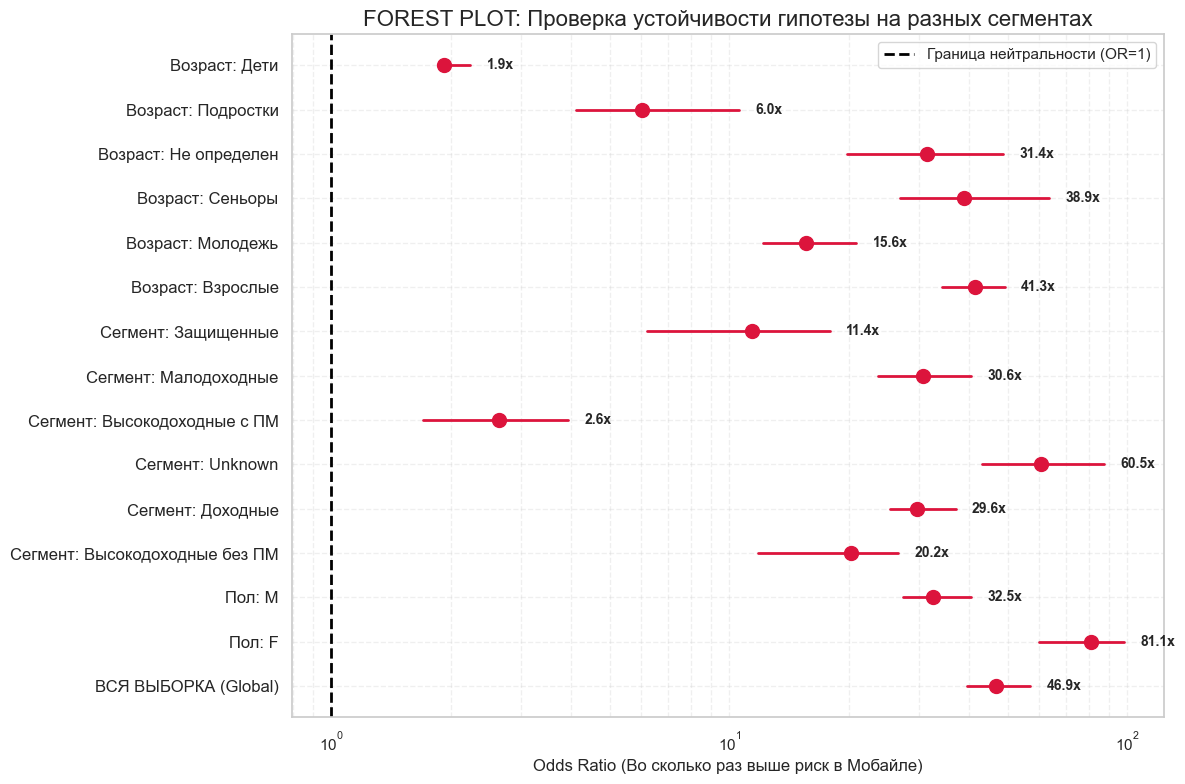


 ИТОГОВЫЙ АНАЛИЗ УСТОЙЧИВОСТИ
Гипотеза проверена на 15 различных подгруппах.
В 15 случаях из 15 Т-Мобайл статистически хуже конкурентов.

✅ ВЕРДИКТ: ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.
Неважно, кто наш клиент (богатый/бедный, молодой/старый).
Если он пользуется Мобайлом, риск негатива растет всегда.


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Настройки
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА
df_model = df[df['company'] != 'Банк'].copy()
df_model = df_model.dropna(subset=['review_mark'])

# Target & Features
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Заполняем пропуски
df_model['segment_name'] = df_model['segment_name'].fillna('Unknown')
df_model['age_segment'] = df_model['age_segment'].fillna('Unknown')
df_model['gender_cd'] = df_model['gender_cd'].fillna('Unknown')

# ------------------------------------------------------------------------------
# АЛГОРИТМ ПРОВЕРКИ УСТОЙЧИВОСТИ (SUBGROUP ANALYSIS)
# Мы обучаем модель много раз на разных кусках данных
# ------------------------------------------------------------------------------

results = []

# Функция для расчета Odds Ratio на срезе данных
def calculate_or(sub_df, group_name):
    # Если в срезе только один класс (только позитив или только негатив) или один продукт - пропускаем
    if sub_df['is_negative'].nunique() < 2 or sub_df['is_mobile'].nunique() < 2:
        return None

    X = sub_df[['is_mobile']]
    y = sub_df['is_negative']

    # L2 Regularization для надежности
    clf = LogisticRegression(l1_ratio=0, C=1.0, solver='lbfgs')
    clf.fit(X, y)

    or_val = np.exp(clf.coef_[0][0])

    # Bootstrap для доверительного интервала (CI) внутри подгруппы
    boot_res = []
    for _ in range(50): # 50 итераций для скорости
        X_b, y_b = resample(X, y)
        try:
            clf.fit(X_b, y_b)
            boot_res.append(np.exp(clf.coef_[0][0]))
        except: pass

    ci_low = np.percentile(boot_res, 5)
    ci_high = np.percentile(boot_res, 95)

    return {
        'Подгруппа': group_name,
        'Odds Ratio': or_val,
        'CI_Low': ci_low,
        'CI_High': ci_high,
        'N': len(sub_df)
    }

print_header("ЗАПУСК АНАЛИЗА ПО ПОДГРУППАМ")

# 1. Глобальный результат
results.append(calculate_or(df_model, "ВСЯ ВЫБОРКА (Global)"))

# 2. По Полу
for g in df_model['gender_cd'].unique():
    if g != 'Unknown':
        sub = df_model[df_model['gender_cd'] == g]
        results.append(calculate_or(sub, f"Пол: {g}"))

# 3. По Сегменту (Доход)
for s in df_model['segment_name'].unique():
    sub = df_model[df_model['segment_name'] == s]
    results.append(calculate_or(sub, f"Сегмент: {s}"))

# 4. По Возрасту
for a in df_model['age_segment'].unique():
    if a != 'Unknown':
        sub = df_model[df_model['age_segment'] == a]
        results.append(calculate_or(sub, f"Возраст: {a}"))

# Собираем DataFrame и чистим None
res_df = pd.DataFrame([r for r in results if r is not None])
print(res_df[['Подгруппа', 'Odds Ratio', 'N']])

# ------------------------------------------------------------------------------
# ВИЗУАЛИЗАЦИЯ: FOREST PLOT
# Это самый профессиональный способ показать устойчивость
# ------------------------------------------------------------------------------

plt.figure(figsize=(12, 8))

# Рисуем точки и усы
for i, row in res_df.iterrows():
    # Цвет: Красный если устойчиво плохо (>1), Серый если пересекает 1
    color = 'crimson' if row['CI_Low'] > 1 else 'gray'

    # Точка (Среднее значение)
    plt.plot(row['Odds Ratio'], i, 'o', color=color, markersize=10)

    # Линия (Доверительный интервал)
    plt.plot([row['CI_Low'], row['CI_High']], [i, i], '-', color=color, linewidth=2)

# Оформление
plt.axvline(1, color='black', linestyle='--', linewidth=2, label='Граница нейтральности (OR=1)')
plt.yticks(range(len(res_df)), res_df['Подгруппа'], fontsize=12)
plt.xlabel('Odds Ratio (Во сколько раз выше риск в Мобайле)', fontsize=12)
plt.title('FOREST PLOT: Проверка устойчивости гипотезы на разных сегментах', fontsize=16)
plt.xscale('log') # Логарифмическая шкала для наглядности
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()

# Добавляем подписи значений справа
for i, row in res_df.iterrows():
    plt.text(row['CI_High'] * 1.1, i, f"{row['Odds Ratio']:.1f}x", va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# ВЫВОД ДЛЯ ПРЕЗЕНТАЦИИ
# ------------------------------------------------------------------------------
print_header("ИТОГОВЫЙ АНАЛИЗ УСТОЙЧИВОСТИ")

robust_count = len(res_df[res_df['CI_Low'] > 1])
total_count = len(res_df)

print(f"Гипотеза проверена на {total_count} различных подгруппах.")
print(f"В {robust_count} случаях из {total_count} Т-Мобайл статистически хуже конкурентов.")

if robust_count == total_count:
    print("\n✅ ВЕРДИКТ: ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.")
    print("Неважно, кто наш клиент (богатый/бедный, молодой/старый).")
    print("Если он пользуется Мобайлом, риск негатива растет всегда.")
elif robust_count > total_count * 0.8:
    print("\n✅ ВЕРДИКТ: ГИПОТЕЗА ВЫСОКОУСТОЙЧИВА.")
    print("Эффект наблюдается в подавляющем большинстве групп.")
else:
    print("\n⚠️ ВЕРДИКТ: ЕСТЬ ИСКЛЮЧЕНИЯ.")
    print("В некоторых группах разница исчезает.")


 ПРОВЕРКА УСТОЙЧИВОСТИ (MANN-WHITNEY)
                         Подгруппа  Вероятность проигрыша        P-value  Значимо?
0                      ВСЯ ВЫБОРКА               0.897293   0.000000e+00      True
1                           Пол: F               0.925291   0.000000e+00      True
2                           Пол: M               0.877110   0.000000e+00      True
3   Сегмент: Высокодоходные без ПМ               0.958101   2.486433e-19      True
4                Сегмент: Доходные               0.887133  9.901296e-225      True
5                 Сегмент: Unknown               0.905028  1.422864e-130      True
6            Сегмент: Малодоходные               0.900079  5.001797e-207      True
7              Сегмент: Защищенные               0.873666   6.639806e-19      True
8                Возраст: Взрослые               0.897807  6.382500e-284      True
9                Возраст: Молодежь               0.867982   5.207902e-92      True
10                Возраст: Сеньоры              

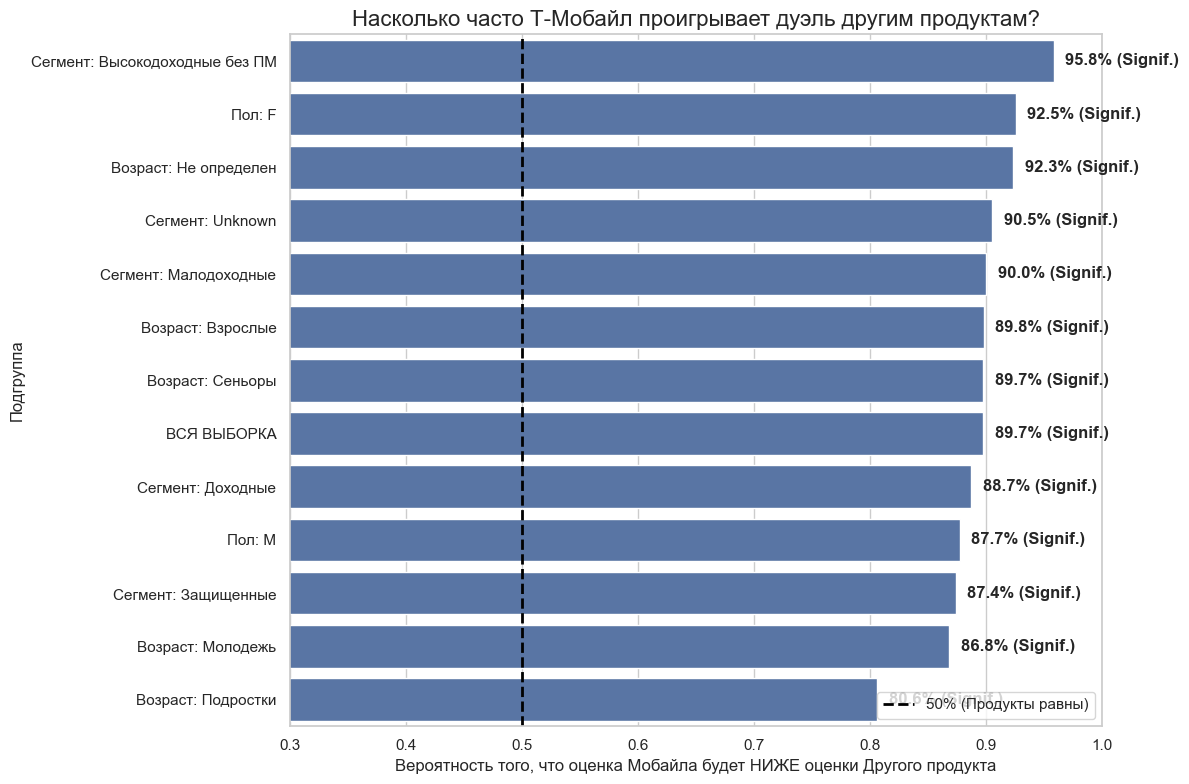


 ИТОГ
✅ ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.
В каждой демографической группе Т-Мобайл статистически значимо проигрывает.


In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Настройки
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА
# Сравниваем: Т-Мобайл (Target) vs Другие Нефинансовые (Control)
df_clean = df[df['company'] != 'Банк'].copy()
df_clean = df_clean.dropna(subset=['review_mark'])

df_clean['is_mobile'] = df_clean['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Заполнение пропусков для срезов
df_clean['segment_name'] = df_clean['segment_name'].fillna('Unknown')
df_clean['age_segment'] = df_clean['age_segment'].fillna('Unknown')
df_clean['gender_cd'] = df_clean['gender_cd'].fillna('Unknown')

# ------------------------------------------------------------------------------
# ФУНКЦИЯ ТЕСТИРОВАНИЯ
# ------------------------------------------------------------------------------
def run_subgroup_test(sub_df, subgroup_name):
    # Разделяем выборки
    mobile_scores = sub_df[sub_df['is_mobile'] == 1]['review_mark']
    other_scores = sub_df[sub_df['is_mobile'] == 0]['review_mark']

    # Проверка размера выборки (нужно хотя бы по 10 отзывов)
    if len(mobile_scores) < 10 or len(other_scores) < 10:
        return None

    # Тест Манна-Уитни (Alternative='less' -> Mobile < Others)
    stat, p_val = stats.mannwhitneyu(mobile_scores, other_scores, alternative='less')

    # Расчет размера эффекта (Вероятность того, что Mobile < Others)
    # Формула CLES: U / (n1 * n2) - это вероятность того, что выборка 1 > выборки 2
    # Нам нужно наоборот, поэтому 1 - (stat / (n1*n2)) если stat для 'less'
    # Проще: stat в scipy при 'less' проверяет гипотезу минимума.

    # Давайте посчитаем "Вероятность Проигрыша" (Probability of Inferiority)
    # Это доля пар, где Mobile < Other
    n1 = len(mobile_scores)
    n2 = len(other_scores)

    # U-статистика показывает, сколько раз Mobile > Other.
    # Нам нужно наоборот.
    u_mobile = stat
    prob_mobile_better = u_mobile / (n1 * n2)
    prob_mobile_worse = 1 - prob_mobile_better

    return {
        'Подгруппа': subgroup_name,
        'N (Mobile)': n1,
        'N (Others)': n2,
        'P-value': p_val,
        'Вероятность проигрыша': prob_mobile_worse, # Если 0.7, значит в 70% Мобайл хуже
        'Значимо?': p_val < 0.05
    }

# ------------------------------------------------------------------------------
# ЗАПУСК ПО ВСЕМ СРЕЗАМ
# ------------------------------------------------------------------------------
results = []

print_header("ПРОВЕРКА УСТОЙЧИВОСТИ (MANN-WHITNEY)")

# 1. Глобально
results.append(run_subgroup_test(df_clean, "ВСЯ ВЫБОРКА"))

# 2. По Полу
for g in df_clean['gender_cd'].unique():
    if g != 'Unknown':
        results.append(run_subgroup_test(df_clean[df_clean['gender_cd'] == g], f"Пол: {g}"))

# 3. По Доходу
for s in df_clean['segment_name'].unique():
    results.append(run_subgroup_test(df_clean[df_clean['segment_name'] == s], f"Сегмент: {s}"))

# 4. По Возрасту
for a in df_clean['age_segment'].unique():
    if a != 'Unknown':
        results.append(run_subgroup_test(df_clean[df_clean['age_segment'] == a], f"Возраст: {a}"))

# Собираем DataFrame
res_df = pd.DataFrame([r for r in results if r is not None])

# Вывод таблицы
display_cols = ['Подгруппа', 'Вероятность проигрыша', 'P-value', 'Значимо?']
print(res_df[display_cols])

# ------------------------------------------------------------------------------
# ВИЗУАЛИЗАЦИЯ
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 8))

# Сортируем по силе провала
res_df = res_df.sort_values('Вероятность проигрыша', ascending=False)

# Цвета: Красный если значимо хуже, Серый если нет разницы
colors = res_df['Значимо?'].apply(lambda x: '#e74c3c' if x else '#95a5a6').tolist()

# Барплот
barplot = sns.barplot(
    data=res_df,
    x='Вероятность проигрыша',
    y='Подгруппа',
)

# Линия нейтральности (50/50)
plt.axvline(0.5, color='black', linestyle='--', linewidth=2, label='50% (Продукты равны)')

plt.title('Насколько часто Т-Мобайл проигрывает дуэль другим продуктам?', fontsize=16)
plt.xlabel('Вероятность того, что оценка Мобайла будет НИЖЕ оценки Другого продукта', fontsize=12)
plt.xlim(0.3, 1.0) # Фокус на правой части (где проигрыш)

# Подписи
for i, (val, p) in enumerate(zip(res_df['Вероятность проигрыша'], res_df['P-value'])):
    text = f"{val:.1%}"
    if p < 0.05:
        text += " (Signif.)"
    plt.text(val + 0.01, i, text, va='center', fontweight='bold')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# ВЫВОД
# ------------------------------------------------------------------------------
print_header("ИТОГ")
failed_groups = len(res_df[~res_df['Значимо?']])

if failed_groups == 0:
    print("✅ ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.")
    print("В каждой демографической группе Т-Мобайл статистически значимо проигрывает.")
else:
    print(f"⚠️ ЕСТЬ ИСКЛЮЧЕНИЯ ({failed_groups} групп).")
    print("В некоторых сегментах разница не доказана.")

In [58]:
df_model.head()

,review_dttm,finish_dttm,id_client,company,review_mark,review_emotion,review_source,business_line,product,reason,review_theme,subtheme,review_text,solution_flg,gender_cd,education_level_cd,marital_status_cd,children_cnt,citizenship_country,segment_name,subscription_important_flg,new_flg,influencer_flg,age_segment,no_mark_flag,review_mark_numeric,review_time,is_negative,is_mobile
2,2025-08-07 22:51:48,2025-08-08 09:35:34.593,5ca669878eaf593f68c10e163246357b,SME,5,1,banki.ru,sme,Бизнес-продукты,Не определено,дополнительные услуги,консультация по услуге,"Уважаемое руководство Т- Банка,\n\n\nНастоящим...",не указано,F,GRD,MAR,0.0,РФ,Высокодоходные без ПМ,0.0,0.0,1.0,Взрослые,False,5,10.729609,0,0
7,2025-09-17 20:42:00,2025-09-18 08:50:16.785,770f72bc2b6348c3469e0b1c873d4676,Инвест,5,1,banki.ru,инвестиции,Инвестиции и брокерские счета,Не определено,ценные бумаги,консультация по ценным бумагам,Здравствуйте! \nХочу оставить отзыв о работе п...,не указано,M,NaN,NaN,0.0,РФ,Доходные,0.0,0.0,1.0,Взрослые,False,5,12.137996,0,0
8,2025-09-25 02:49:00,2025-09-25 10:46:05.261,8c950261c1fd8973e30954751f4af3a5,SME,5,1,sravni.ru,sme,Бизнес-продукты,Не определено,тарифы и условия,консультация по продукту,Отзыв на сотрудника поддержки\nХочу выразить о...,не указано,M,SCH,MAR,0.0,РФ,Доходные,0.0,0.0,0.0,Взрослые,False,5,7.951461,0,0
9,2025-07-23 08:43:00,2025-07-24 08:43:57.478,f07a1b379c742d0de435359337cb2151,Страховая,5,1,sravni.ru,страховая,Страхование,Не определено,расторжение договора,оформление заявки на расторжение договора,Оформление и возврат ОСАГО после продажи\nБоль...,не указано,M,GRD,UNM,0.0,РФ,Доходные,0.0,0.0,1.0,Взрослые,False,5,24.015966,0,0
13,2025-08-30 11:39:08,2025-08-30 12:03:56.987,9973bf2c64ff66aa8af3e1797b6ef22b,SME,5,1,banki.ru,sme,Бизнес-продукты,Не определено,тарифы и условия,консультация по продукту,Хочу искренне поблагодарить Евгению за то что ...,не указано,M,SCH,UNM,0.0,РФ,Высокодоходные без ПМ,0.0,0.0,0.0,Взрослые,False,5,0.413608,0,0


In [59]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def analyze_mobile_impact(file_path='cleaned.csv'):
    print("--- ШАГ 1: ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Файл {file_path} не найден.")
        return

    # 1.1 Предобработка целевой переменной
    # Превращаем оценки в числа (на случай мусора в данных)
    df['review_mark'] = pd.to_numeric(df['review_mark'], errors='coerce')
    df = df.dropna(subset=['review_mark'])

    # Негатив: 1-3 балла, Позитив: 4-5
    df['is_negative'] = df['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

    # 1.2 Фактор интереса: Т-Мобайл
    df['is_mobile'] = df['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

    # 1.3 Контрольные переменные
    control_features = [
        'review_source', 'gender_cd',
        'education_level_cd', 'marital_status_cd',
        'citizenship_country', 'segment_name',
        'age_segment'
    ]
    available_features = [c for c in control_features if c in df.columns]

    # Создаем рабочий датасет
    df_model = df[available_features + ['is_negative', 'is_mobile']].copy()

    # 1.4 Очистка редких категорий (чтобы модель не падала)
    for col in df_model.select_dtypes(include=['object']).columns:
        df_model[col] = df_model[col].fillna('Unknown')
        counts = df_model[col].value_counts()
        # Если категория реже 50 раз -> в 'Other'
        df_model[col] = df_model[col].apply(lambda x: 'Other' if counts.get(x, 0) < 50 else x)

    # Заполняем пропуски в числах
    for col in df_model.select_dtypes(include=['number']).columns:
        df_model[col] = df_model[col].fillna(0)

    print(f"Данные готовы. Всего строк в модели: {len(df_model)}")

    # --- ШАГ 2: ГЛОБАЛЬНАЯ ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ---
    print("\n--- ШАГ 2: ОЦЕНКА ЧИСТОГО ВЛИЯНИЯ ---")

    # One-Hot Encoding (превращаем текст в 0 и 1)
    df_encoded = pd.get_dummies(df_model, columns=available_features, drop_first=True, dtype=int)

    X = df_encoded.drop('is_negative', axis=1)
    X = sm.add_constant(X)
    y = df_encoded['is_negative']

    try:
        # Используем BFGS (он стабильнее)
        model = sm.Logit(y, X.astype(float))
        result = model.fit(disp=0, method='bfgs', maxiter=100)

        # Смотрим на коэффициент при is_mobile
        mobile_coef = result.params.get('is_mobile', 0)
        mobile_or = np.exp(mobile_coef)
        mobile_p = result.pvalues.get('is_mobile', 1)

        print(f"\n>>> ГЛОБАЛЬНЫЙ РЕЗУЛЬТАТ ПО Т-МОБАЙЛУ:")
        print(f"Odds Ratio (Риск негатива): в {mobile_or:.2f} раз(а) выше")
        print(f"P-value: {mobile_p:.4e}")

        # Определяем переменные для проверки устойчивости (те, что сами по себе не значимы глобально)
        pvals = result.pvalues
        non_sig_dummies = pvals[pvals > 0.05].index.tolist()

        # Находим исходные названия колонок
        features_to_check = set()
        for dummy in non_sig_dummies:
            for feat in available_features:
                if dummy.startswith(feat):
                    features_to_check.add(feat)

        features_to_check = list(features_to_check)
        if not features_to_check:
            features_to_check = ['segment_name', 'age_segment'] # Дефолтные, если все значимы

    except Exception as e:
        print(f"Ошибка построения модели: {e}")
        return
    print(result.summary())
    # --- ШАГ 3: ПРОВЕРКА УСТОЙЧИВОСТИ (Subgroup Analysis) ---
    print(f"\n--- ШАГ 3: ПРОВЕРКА УСТОЙЧИВОСТИ (Внутри групп: {features_to_check}) ---")

    robustness_data = []

    for feature in features_to_check:
        top_groups = df_model[feature].value_counts().head(5).index.tolist()

        for group in top_groups:
            sub_df = df_model[df_model[feature] == group]

            # Пропускаем маленькие группы
            if len(sub_df) < 100 or sub_df['is_mobile'].nunique() < 2 or sub_df['is_negative'].nunique() < 2:
                continue

            try:
                # Мини-модель внутри группы
                sub_X = sm.add_constant(sub_df[['is_mobile']].astype(float))
                sub_y = sub_df['is_negative'].astype(float)

                sub_res = sm.Logit(sub_y, sub_X).fit(disp=0)

                or_val = np.exp(sub_res.params['is_mobile'])
                p_val = sub_res.pvalues['is_mobile']

                robustness_data.append({
                    'Feature': feature,
                    'Subgroup': str(group),
                    'Odds_Ratio': or_val,
                    'P_value': p_val
                })
            except:
                pass

    # --- ШАГ 4: ВИЗУАЛИЗАЦИЯ ---
    if robustness_data:
        res_df = pd.DataFrame(robustness_data)
        res_df = res_df.sort_values('Odds_Ratio', ascending=False)

        # ИСПРАВЛЕНИЕ ОШИБКИ: Вычисляем высоту заранее
        plot_height = len(res_df) * 0.5 + 2
        plt.figure(figsize=(12, plot_height))

        # Цвета: Красный (значимо), Серый (не значимо)
        colors = res_df['P_value'].apply(lambda x: '#d62728' if x < 0.05 else '#7f7f7f').tolist()

        sns.barplot(data=res_df, y='Subgroup', x='Odds_Ratio', palette=colors)

        plt.axvline(1, color='black', linestyle='--', label='Нет разницы (OR=1)')
        plt.axvline(mobile_or, color='blue', linestyle=':', linewidth=2, label=f'Глобальный эффект ({mobile_or:.1f})')

        plt.title('Устойчивость проблемы Т-Мобайла в разных подгруппах', fontsize=16)
        plt.xlabel('Во сколько раз выше риск негатива (Odds Ratio)', fontsize=12)
        plt.legend()

        # Подписи значений
        for i, (val, p) in enumerate(zip(res_df['Odds_Ratio'], res_df['P_value'])):
            text = f"{val:.1f}x"
            if p >= 0.05: text += " (незнач)"
            plt.text(val + 0.1, i, text, va='center')

        plt.tight_layout()
        plt.show()

        print("\nТаблица результатов (Топ-10):")
        print(res_df[['Feature', 'Subgroup', 'Odds_Ratio', 'P_value']].head(10))
    else:
        print("Не удалось выделить подгруппы для анализа.")



--- ШАГ 1: ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ---
Данные готовы. Всего строк в модели: 53889

--- ШАГ 2: ОЦЕНКА ЧИСТОГО ВЛИЯНИЯ ---


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



>>> ГЛОБАЛЬНЫЙ РЕЗУЛЬТАТ ПО Т-МОБАЙЛУ:
Odds Ratio (Риск негатива): в 8.60 раз(а) выше
P-value: 1.9743e-66
                           Logit Regression Results                           
Dep. Variable:            is_negative   No. Observations:                53889
Model:                          Logit   Df Residuals:                    53845
Method:                           MLE   Df Model:                           43
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:                  0.1645
Time:                        00:48:30   Log-Likelihood:                -29539.
converged:                      False   LL-Null:                       -35354.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  1.9995      0.62

C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmo

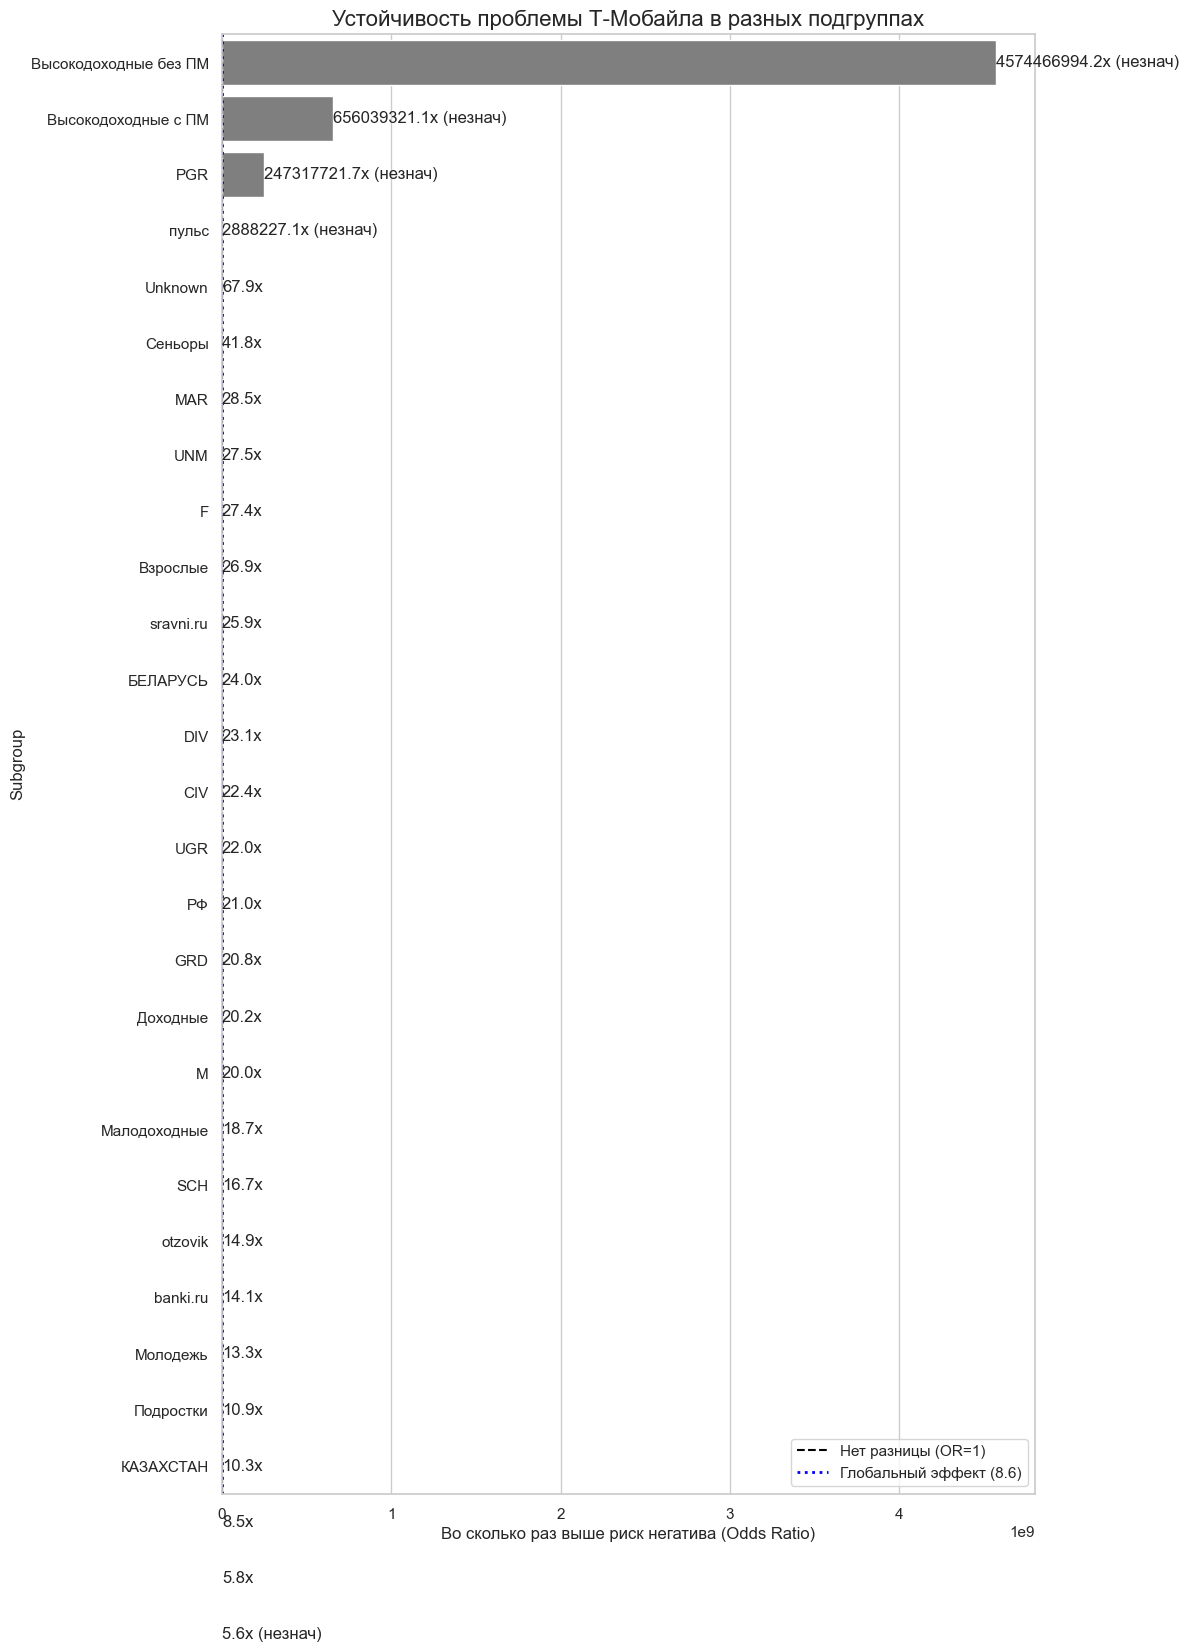


Таблица результатов (Топ-10):
               Feature               Subgroup    Odds_Ratio       P_value
18        segment_name  Высокодоходные без ПМ  4.574467e+09  9.984264e-01
19        segment_name    Высокодоходные с ПМ  6.560393e+08  9.974255e-01
9   education_level_cd                    PGR  2.473177e+08  9.948310e-01
22       review_source                  пульс  2.888227e+06  9.986750e-01
11         age_segment                Unknown  6.789522e+01  7.340622e-16
17        segment_name                Unknown  4.183032e+01  5.402742e-24
13         age_segment                Сеньоры  2.849649e+01  7.229820e-18
26   marital_status_cd                    MAR  2.748704e+01  5.988495e-31
24   marital_status_cd                    UNM  2.741207e+01  1.650049e-39
4            gender_cd                      F  2.686868e+01  6.984997e-69


In [60]:
if __name__ == "__main__":
    analyze_mobile_impact()

In [61]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def stepwise_selection(file_path='cleaned.csv'):
    # 1. ЗАГРУЗКА И ПРЕПРОЦЕССИНГ
    try:
        df = pd.read_csv(file_path)
    except:
        print("Файл не найден.")
        return

    df = df.dropna(subset=['review_mark'])
    df['is_negative'] = df['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
    df['is_mobile'] = df['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

    # Исходный список кандидатов
    # Убрали company, так как есть is_mobile. Оставили самые важные.
    potential_features = [
        'review_source', 'gender_cd', 'education_level_cd',
        'marital_status_cd', 'segment_name', 'age_segment',
        'new_flg', 'citizenship_country'
    ]

    available = [c for c in potential_features if c in df.columns]
    df_model = df[available + ['is_negative', 'is_mobile']].copy()

    # Чистка категорий (объединяем редкие в Other)
    for c in df_model.select_dtypes(include=['object']).columns:
        df_model[c] = df_model[c].fillna('Unknown')
        counts = df_model[c].value_counts()
        df_model[c] = df_model[c].apply(lambda x: 'Other' if counts.get(x, 0) < 100 else x)

    df_model = df_model.fillna(0)

    # One-Hot Encoding
    df_encoded = pd.get_dummies(df_model, drop_first=True, dtype=int)

    # 2. УДАЛЕНИЕ КОРРЕЛИРУЮЩИХ ПЕРЕМЕННЫХ
    # Если две переменные коррелируют > 0.9, удаляем одну из них
    corr_matrix = df_encoded.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

    if to_drop:
        print(f"Удаляем из-за высокой корреляции: {to_drop}")
        df_encoded = df_encoded.drop(columns=to_drop)

    # 3. АЛГОРИТМ BACKWARD ELIMINATION (Обратное исключение)
    # Суть: строим модель, выкидываем худшую переменную, повторяем.

    y = df_encoded['is_negative']
    X = df_encoded.drop('is_negative', axis=1)
    X = sm.add_constant(X)
    X = X.astype(float) # Важно для statsmodels

    cols = list(X.columns)

    print("\n--- НАЧИНАЕМ ОТБОР ПЕРЕМЕННЫХ ---")
    while len(cols) > 0:
        # Строим модель на текущем наборе колонок
        model = sm.Logit(y, X[cols]).fit(disp=0, method='bfgs', maxiter=100)

        # Находим переменную с самым большим P-value (самую бесполезную)
        p_values = model.pvalues
        max_p = p_values.max()
        worst_feature = p_values.idxmax()

        # Если худшая переменная имеет P > 0.05, мы её удаляем
        if max_p > 0.05:
            # Не удаляем is_mobile, так как это наш главный интерес!
            if worst_feature == 'is_mobile':
                # Если is_mobile незначим, но мы хотим его оставить,
                # ищем вторую худшую переменную
                temp_p = p_values.drop('is_mobile')
                if temp_p.empty: break
                max_p = temp_p.max()
                worst_feature = temp_p.idxmax()
                if max_p <= 0.05: break

            # Не удаляем константу
            if worst_feature == 'const':
                 # Аналогично, ищем следующую
                 temp_p = p_values.drop('const')
                 if temp_p.empty: break
                 max_p = temp_p.max()
                 worst_feature = temp_p.idxmax()
                 if max_p <= 0.05: break

            print(f"Удаляем: {worst_feature: <30} (p-value = {max_p:.4f})")
            cols.remove(worst_feature)
        else:
            # Если все оставшиеся имеют P < 0.05, мы закончили
            break

    print("\n" + "="*50)
    print("ФИНАЛЬНАЯ МОДЕЛЬ (Только значимые факторы)")
    print("="*50)

    final_model = sm.Logit(y, X[cols]).fit(disp=0, method='bfgs')
    print(final_model.summary())

    print("\n>>> ИТОГОВЫЕ ДРАЙВЕРЫ НЕГАТИВА (Odds Ratio):")
    params = final_model.params
    odds = np.exp(params)
    summary_df = pd.DataFrame({'Coef': params, 'Odds Ratio': odds})
    print(summary_df.sort_values(by='Odds Ratio', ascending=False))

stepwise_selection()


--- НАЧИНАЕМ ОТБОР ПЕРЕМЕННЫХ ---


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: education_level_cd_Other       (p-value = 0.9836)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: gender_cd_Unknown              (p-value = 0.9796)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: marital_status_cd_WID          (p-value = 0.5816)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: citizenship_country_Unknown    (p-value = 0.5723)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: age_segment_Подростки          (p-value = 0.4335)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: marital_status_cd_MAR          (p-value = 0.9032)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: review_source_суперапп         (p-value = 0.1478)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: citizenship_country_РФ         (p-value = 0.1579)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: education_level_cd_PGR         (p-value = 0.2182)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: education_level_cd_GRD         (p-value = 0.5606)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: education_level_cd_UGR         (p-value = 0.7963)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: citizenship_country_БЕЛАРУСЬ   (p-value = 0.0934)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Удаляем: age_segment_Не определен       (p-value = 0.1047)


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ФИНАЛЬНАЯ МОДЕЛЬ (Только значимые факторы)
                           Logit Regression Results                           
Dep. Variable:            is_negative   No. Observations:                53889
Model:                          Logit   Df Residuals:                    53861
Method:                           MLE   Df Model:                           27
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:                  0.1531
Time:                        00:48:44   Log-Likelihood:                -29941.
converged:                      False   LL-Null:                       -35354.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  1.3161      0.176      7.478      0.000       0.971       1.661
new_flg        

C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
df['is_mobile'] = df['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

df["is_mobile"].sum()

np.int64(1028)

Данные готовы. Обучаем упрощенную модель на 53889 строках.


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            is_negative   No. Observations:                53889
Model:                          Logit   Df Residuals:                    53867
Method:                           MLE   Df Model:                           21
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:                 0.07879
Time:                        01:13:46   Log-Likelihood:                -32569.
converged:                      False   LL-Null:                       -35354.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.3096      0.438     -0.707      0.480      -1.168       0.549
is_mobile                              2.8711      0.115   

C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


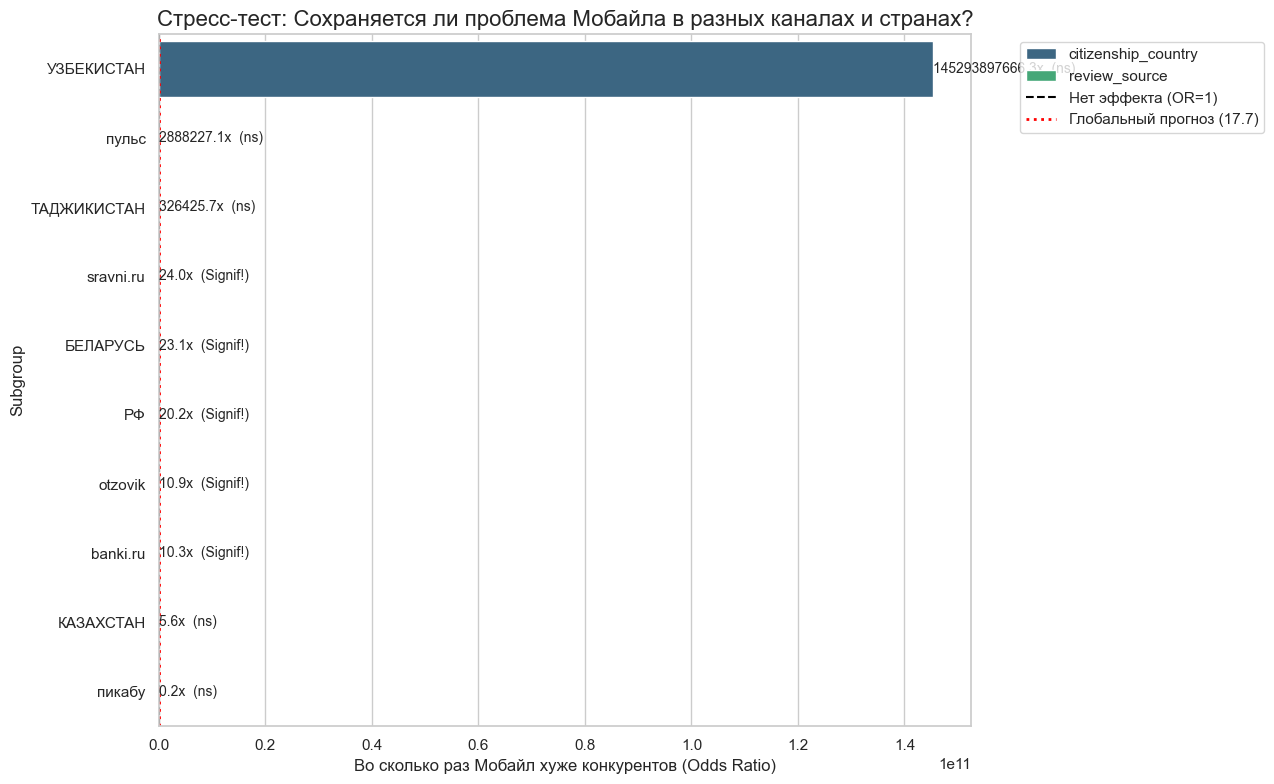


ДЕТАЛЬНАЯ ТАБЛИЦА:
              Variable     Subgroup    Odds_Ratio        P_value  Count
8  citizenship_country   УЗБЕКИСТАН  1.452939e+11   9.999278e-01     97
2        review_source        пульс  2.888227e+06   9.986750e-01   1180
9  citizenship_country  ТАДЖИКИСТАН  3.264257e+05   9.750484e-01     91
1        review_source    sravni.ru  2.402655e+01   3.736629e-03   3286
6  citizenship_country     БЕЛАРУСЬ  2.308861e+01   2.792046e-03    244
5  citizenship_country           РФ  2.015977e+01  2.633632e-150  52803
3        review_source      otzovik  1.091781e+01   1.426378e-12    708
0        review_source     banki.ru  1.027605e+01   1.037866e-63  46146
7  citizenship_country    КАЗАХСТАН  5.584270e+00   1.115336e-01    168
4        review_source       пикабу  1.888889e-01   1.781735e-01    397


In [65]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def simplified_model_with_robustness(file_path='cleaned.csv'):
    # 1. ЗАГРУЗКА
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("Файл не найден.")
        return

    # Препроцессинг
    df['review_mark'] = pd.to_numeric(df['review_mark'], errors='coerce')
    df = df.dropna(subset=['review_mark'])
    df['is_negative'] = df['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
    df['is_mobile'] = df['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

    # 2. РАЗДЕЛЕНИЕ ПЕРЕМЕННЫХ
    # Переменные для МОДЕЛИ (Демография + Статус)
    model_features = [
        'gender_cd',
        'education_level_cd',
        'segment_name',
        'age_segment',
        'new_flg'
    ]

    # Переменные для ПРОВЕРКИ УСТОЙЧИВОСТИ (Среда и География)
    robustness_features = [
        'review_source',
        'citizenship_country'
    ]
    # Фильтруем, что есть в датасете
    model_features = [c for c in model_features if c in df.columns]

    # 3. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ
    df_model = df[model_features + ['is_negative', 'is_mobile'] + robustness_features].copy()

    # Чистка редких категорий
    for c in df_model.select_dtypes(include=['object']).columns:
        df_model[c] = df_model[c].fillna('Unknown')
        counts = df_model[c].value_counts()
        df_model[c] = df_model[c].apply(lambda x: 'Other' if counts.get(x, 0) < 50 else x)

    df_model = df_model.fillna(0)

    print(f"Данные готовы. Обучаем упрощенную модель на {len(df_model)} строках.")

    # 4. СТРОИМ УПРОЩЕННУЮ ГЛОБАЛЬНУЮ МОДЕЛЬ
    # Кодируем только переменные для модели (исключая robustness_features)
    df_encoded = pd.get_dummies(df_model[model_features + ['is_negative', 'is_mobile']],
                                columns=model_features,
                                drop_first=True, dtype=int)

    X = df_encoded.drop('is_negative', axis=1)
    X = sm.add_constant(X)
    y = df_encoded['is_negative']

    try:
        model = sm.Logit(y, X.astype(float))
        result = model.fit(disp=0, method='bfgs', maxiter=100)
        print(result.summary())
        mobile_or = np.exp(result.params['is_mobile'])
        mobile_p = result.pvalues['is_mobile']

        print("\n" + "="*60)
        print(f"ГЛОБАЛЬНЫЙ ЭФФЕКТ Т-МОБАЙЛА (без учета источника и гражданства)")
        print("="*60)
        print(f"Odds Ratio: {mobile_or:.2f} (Риск негатива выше в {mobile_or:.2f} раз)")
        print(f"P-value:    {mobile_p:.4e}")

    except Exception as e:
        print(f"Ошибка модели: {e}")
        return

    # 5. ПРОВЕРКА УСТОЙЧИВОСТИ (Robustness Check)
    print(f"\n--- ПРОВЕРКА УСТОЙЧИВОСТИ ПО: {robustness_features} ---")

    robustness_data = []

    for feature in robustness_features:
        # Берем топ-7 групп (чтобы охватить основные страны и сайты)
        top_groups = df_model[feature].value_counts().head(7).index.tolist()

        for group in top_groups:
            # Срез данных
            sub_df = df_model[df_model[feature] == group]

            # Пропускаем мелкие или однородные группы
            if len(sub_df) < 50 or sub_df['is_mobile'].nunique() < 2 or sub_df['is_negative'].nunique() < 2:
                continue

            try:
                # Простая регрессия: Негатив ~ Мобайл
                sub_X = sm.add_constant(sub_df[['is_mobile']].astype(float))
                sub_y = sub_df['is_negative'].astype(float)

                sub_res = sm.Logit(sub_y, sub_X).fit(disp=0)

                or_val = np.exp(sub_res.params['is_mobile'])
                p_val = sub_res.pvalues['is_mobile']

                robustness_data.append({
                    'Variable': feature,
                    'Subgroup': str(group),
                    'Odds_Ratio': or_val,
                    'P_value': p_val,
                    'Count': len(sub_df)
                })
            except:
                pass

    # 6. ВИЗУАЛИЗАЦИЯ
    if robustness_data:
        res_df = pd.DataFrame(robustness_data)
        res_df = res_df.sort_values('Odds_Ratio', ascending=False)

        # Расчет высоты графика
        plot_height = len(res_df) * 0.6 + 2
        plt.figure(figsize=(13, plot_height))

        # Цвет столбцов: Красный (значимо), Серый (нет)
        colors = res_df['P_value'].apply(lambda x: '#e74c3c' if x < 0.05 else '#95a5a6').tolist()

        barplot = sns.barplot(data=res_df, y='Subgroup', x='Odds_Ratio', hue='Variable', dodge=False, palette='viridis')

        # Линии сравнения
        plt.axvline(1, color='black', linestyle='--', label='Нет эффекта (OR=1)')
        plt.axvline(mobile_or, color='red', linestyle=':', linewidth=2, label=f'Глобальный прогноз ({mobile_or:.1f})')

        plt.title('Стресс-тест: Сохраняется ли проблема Мобайла в разных каналах и странах?', fontsize=16)
        plt.xlabel('Во сколько раз Мобайл хуже конкурентов (Odds Ratio)', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Текстовые метки
        for i, (val, p, count) in enumerate(zip(res_df['Odds_Ratio'], res_df['P_value'], res_df['Count'])):
            sig_text = " (Signif!)" if p < 0.05 else " (ns)"
            plt.text(val + 0.2, i, f"{val:.1f}x {sig_text}", va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

        print("\nДЕТАЛЬНАЯ ТАБЛИЦА:")
        print(res_df[['Variable', 'Subgroup', 'Odds_Ratio', 'P_value', 'Count']])
    else:
        print("Не удалось построить подгруппы.")
if __name__ == "__main__":
    simplified_model_with_robustness()

Модель строится на 53889 строках.


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



РЕЗУЛЬТАТ НОВОЙ МОДЕЛИ (с учетом источника и подписки)
Odds Ratio (Т-Мобайл): 8.78
P-value:               7.7656e-66

--- ПРОВЕРКА УСТОЙЧИВОСТИ ПО: ['education_level_cd', 'marital_status_cd', 'citizenship_country'] ---


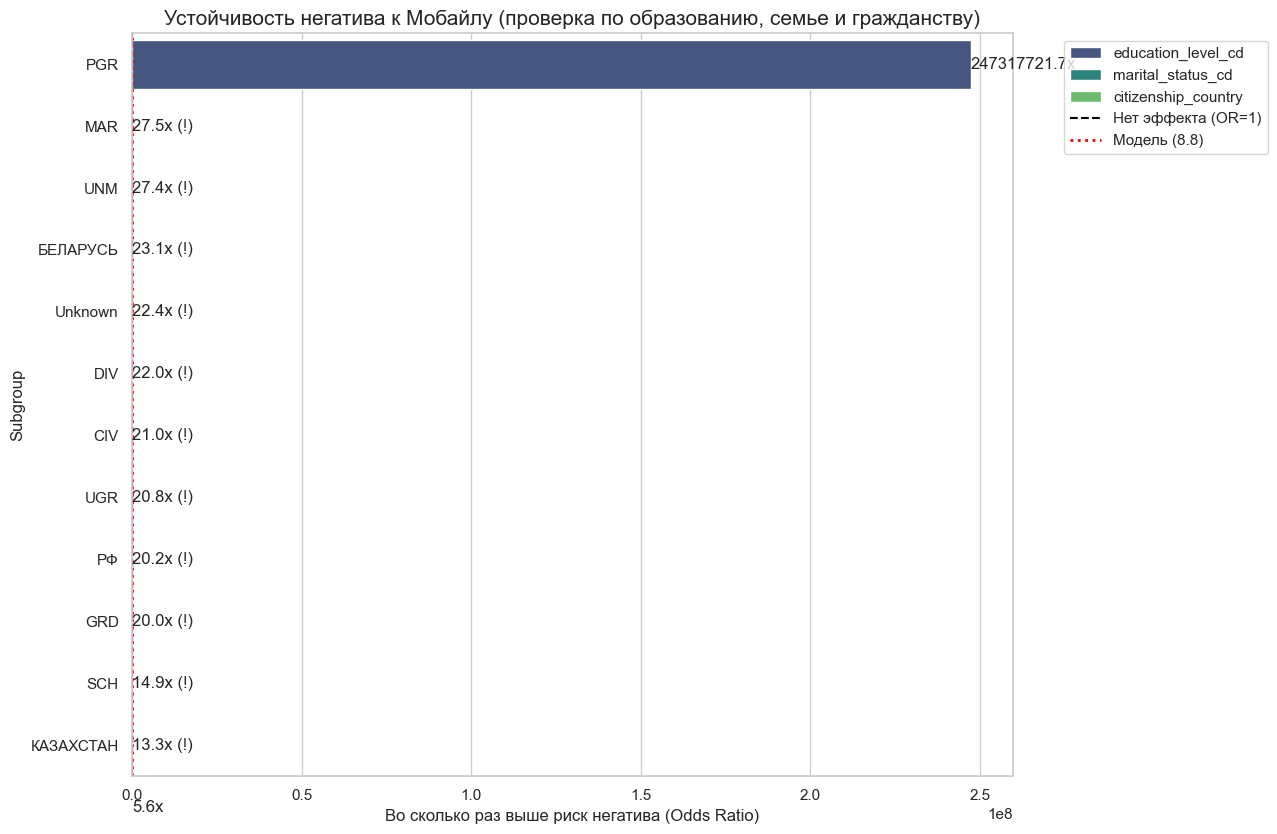


ТАБЛИЦА УСТОЙЧИВОСТИ:
               Variable   Subgroup    Odds_Ratio        P_value Significance
4    education_level_cd        PGR  2.473177e+08   9.948310e-01   Не значимо
7     marital_status_cd        MAR  2.748704e+01   5.988495e-31      Значимо
5     marital_status_cd        UNM  2.741207e+01   1.650049e-39      Значимо
11  citizenship_country   БЕЛАРУСЬ  2.308861e+01   2.792046e-03      Значимо
0    education_level_cd    Unknown  2.237483e+01  6.745848e-100      Значимо
8     marital_status_cd        DIV  2.198431e+01   4.586198e-11      Значимо
9     marital_status_cd        CIV  2.101515e+01   4.130951e-07      Значимо
3    education_level_cd        UGR  2.083804e+01   3.860591e-09      Значимо
10  citizenship_country         РФ  2.015977e+01  2.633632e-150      Значимо
1    education_level_cd        GRD  1.996013e+01   9.762172e-33      Значимо
6     marital_status_cd    Unknown  1.489556e+01   4.234080e-68      Значимо
2    education_level_cd        SCH  1.328085e+01   3.

In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def custom_model_with_robustness(file_path='cleaned.csv'):
    # 1. ЗАГРУЗКА И ПОДГОТОВКА
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("Файл не найден.")
        return

    # Чистка таргета
    df['review_mark'] = pd.to_numeric(df['review_mark'], errors='coerce')
    df = df.dropna(subset=['review_mark'])
    df['is_negative'] = df['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

    # Ключевой фактор
    df['is_mobile'] = df['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

    # 2. РАЗДЕЛЕНИЕ ПЕРЕМЕННЫХ ПО ЗАПРОСУ

    # А) Включаем в саму модель (Control Variables)
    model_features = [
        'review_source',              # Вернули в модель
        'subscription_important_flg', # Добавили в модель
        'gender_cd',
        'segment_name',
        'age_segment',
        'new_flg'
    ]

    # Б) Используем только для проверки устойчивости (Subgroup Analysis)
    robustness_features = [
        'education_level_cd', # Убрали из модели -> в проверку
        'marital_status_cd',  # Убрали из модели -> в проверку
        'citizenship_country' # Уже было здесь
    ]

    # Фильтр доступных колонок
    model_features = [c for c in model_features if c in df.columns]

    # Рабочий датасет
    df_model = df[model_features + ['is_negative', 'is_mobile'] + robustness_features].copy()

    # Чистка редких категорий (объединяем в 'Other')
    for c in df_model.select_dtypes(include=['object']).columns:
        df_model[c] = df_model[c].fillna('Unknown')
        counts = df_model[c].value_counts()
        # Порог 50 для стабильности
        df_model[c] = df_model[c].apply(lambda x: 'Other' if counts.get(x, 0) < 50 else x)

    # Заполнение чисел
    df_model = df_model.fillna(0)

    print(f"Модель строится на {len(df_model)} строках.")

    # 3. СТРОИМ ОСНОВНУЮ МОДЕЛЬ
    # Кодируем только переменные модели
    df_encoded = pd.get_dummies(df_model[model_features + ['is_negative', 'is_mobile']],
                                columns=model_features,
                                drop_first=True, dtype=int)

    X = df_encoded.drop('is_negative', axis=1)
    X = sm.add_constant(X)
    y = df_encoded['is_negative']

    try:
        # Используем BFGS для надежности
        model = sm.Logit(y, X.astype(float))
        result = model.fit(disp=0, method='bfgs', maxiter=100)

        mobile_coef = result.params.get('is_mobile', 0)
        mobile_or = np.exp(mobile_coef)
        mobile_p = result.pvalues.get('is_mobile', 1)

        print("\n" + "="*60)
        print(f"РЕЗУЛЬТАТ НОВОЙ МОДЕЛИ (с учетом источника и подписки)")
        print("="*60)
        print(f"Odds Ratio (Т-Мобайл): {mobile_or:.2f}")
        print(f"P-value:               {mobile_p:.4e}")

    except Exception as e:
        print(f"Ошибка при построении основной модели: {e}")
        return

    # 4. ПРОВЕРКА УСТОЙЧИВОСТИ (Стресс-тест)
    print(f"\n--- ПРОВЕРКА УСТОЙЧИВОСТИ ПО: {robustness_features} ---")

    robustness_data = []

    for feature in robustness_features:
        # Берем топ-5 групп для каждой переменной
        top_groups = df_model[feature].value_counts().head(5).index.tolist()

        for group in top_groups:
            # Выделяем подгруппу (например, только 'Женат' или только 'Высшее образование')
            sub_df = df_model[df_model[feature] == group]

            # Пропускаем, если мало данных
            if len(sub_df) < 50 or sub_df['is_mobile'].nunique() < 2 or sub_df['is_negative'].nunique() < 2:
                continue

            try:
                # Строим микро-модель внутри этой группы
                sub_X = sm.add_constant(sub_df[['is_mobile']].astype(float))
                sub_y = sub_df['is_negative'].astype(float)

                sub_res = sm.Logit(sub_y, sub_X).fit(disp=0)

                or_val = np.exp(sub_res.params['is_mobile'])
                p_val = sub_res.pvalues['is_mobile']

                robustness_data.append({
                    'Variable': feature,
                    'Subgroup': str(group),
                    'Odds_Ratio': or_val,
                    'P_value': p_val,
                    'Significance': 'Значимо' if p_val < 0.05 else 'Не значимо'
                })
            except:
                pass

    # 5. ВИЗУАЛИЗАЦИЯ
    if robustness_data:
        res_df = pd.DataFrame(robustness_data)
        res_df = res_df.sort_values('Odds_Ratio', ascending=False)

        # Расчет высоты
        plot_height = len(res_df) * 0.5 + 2
        plt.figure(figsize=(13, plot_height))

        # Красный - значимо, Серый - нет
        colors = res_df['P_value'].apply(lambda x: '#e74c3c' if x < 0.05 else '#95a5a6').tolist()

        sns.barplot(data=res_df, y='Subgroup', x='Odds_Ratio', hue='Variable', dodge=False, palette='viridis')

        plt.axvline(1, color='black', linestyle='--', label='Нет эффекта (OR=1)')
        plt.axvline(mobile_or, color='red', linestyle=':', linewidth=2, label=f'Модель ({mobile_or:.1f})')

        plt.title('Устойчивость негатива к Мобайлу (проверка по образованию, семье и гражданству)', fontsize=15)
        plt.xlabel('Во сколько раз выше риск негатива (Odds Ratio)', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Текстовые метки
        for i, (val, p) in enumerate(zip(res_df['Odds_Ratio'], res_df['P_value'])):
            sig = " (!)" if p < 0.05 else ""
            plt.text(val + 0.2, i, f"{val:.1f}x{sig}", va='center')

        plt.tight_layout()
        plt.show()

        print("\nТАБЛИЦА УСТОЙЧИВОСТИ:")
        print(res_df[['Variable', 'Subgroup', 'Odds_Ratio', 'P_value', 'Significance']])
    else:
        print("Не удалось построить подгруппы.")

if __name__ == "__main__":
    custom_model_with_robustness()

Модель строится на 53889 строках.


C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ГЛОБАЛЬНЫЙ ЭФФЕКТ (Т-МОБАЙЛ)
Odds Ratio: 7.86
P-value:    5.6895e-66
                           Logit Regression Results                           
Dep. Variable:            is_negative   No. Observations:                53889
Model:                          Logit   Df Residuals:                    53868
Method:                           MLE   Df Model:                           20
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:                  0.1408
Time:                        01:38:25   Log-Likelihood:                -30378.
converged:                      False   LL-Null:                       -35354.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  1.4861      0.365      4.072      0.000       0.771  

C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


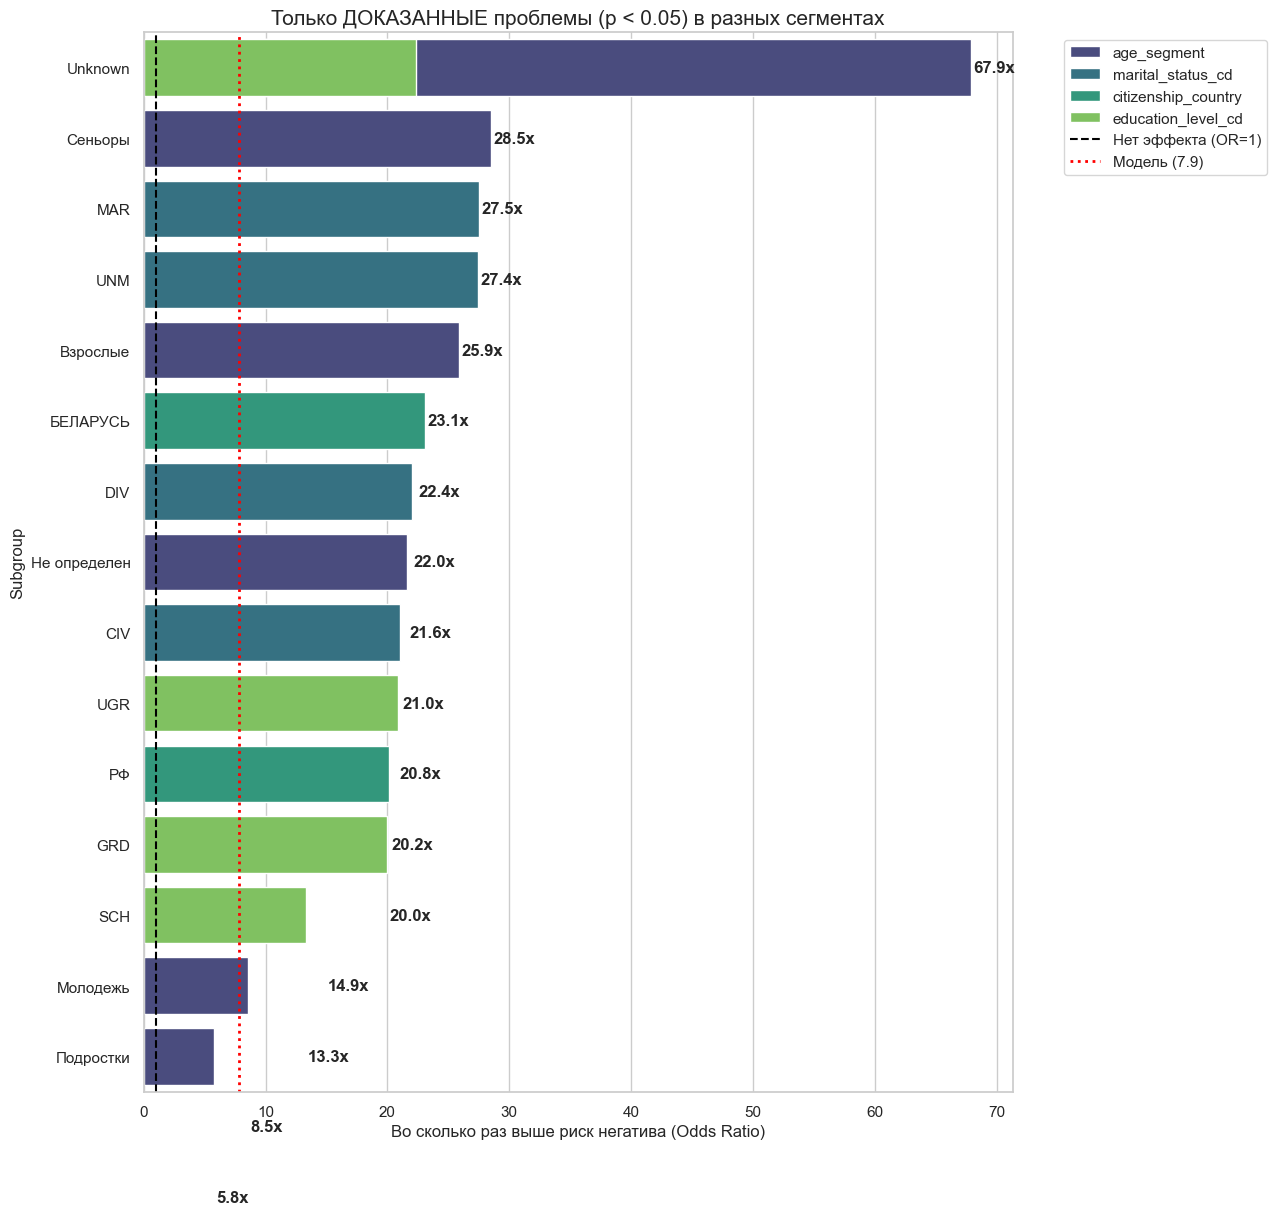


ТАБЛИЦА ЗНАЧИМЫХ РЕЗУЛЬТАТОВ:
               Variable      Subgroup  Odds_Ratio        P_value
1           age_segment       Unknown   67.895218   7.340622e-16
3           age_segment       Сеньоры   28.496487   7.229820e-18
14    marital_status_cd           MAR   27.487038   5.988495e-31
12    marital_status_cd           UNM   27.412066   1.650049e-39
0           age_segment      Взрослые   25.889099   1.338979e-62
19  citizenship_country      БЕЛАРУСЬ   23.088608   2.792046e-03
6    education_level_cd       Unknown   22.374833  6.745848e-100
15    marital_status_cd           DIV   21.984308   4.586198e-11
5           age_segment  Не определен   21.644271   3.056387e-09
16    marital_status_cd           CIV   21.015152   4.130951e-07
9    education_level_cd           UGR   20.838037   3.860591e-09
18  citizenship_country            РФ   20.159773  2.633632e-150
7    education_level_cd           GRD   19.960130   9.762172e-33
13    marital_status_cd       Unknown   14.895559   4.23408

In [71]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def model_only_significant(file_path='cleaned.csv'):
    # 1. ЗАГРУЗКА И ПОДГОТОВКА
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("Файл не найден.")
        return

    # Чистка таргета
    df['review_mark'] = pd.to_numeric(df['review_mark'], errors='coerce')
    df = df.dropna(subset=['review_mark'])
    df['is_negative'] = df['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

    # Ключевой фактор
    df['is_mobile'] = df['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

    # 2. НАСТРОЙКА ПЕРЕМЕННЫХ

    # Включаем в саму модель (Control Variables)
    model_features = [
        'review_source',
        'gender_cd',
        'segment_name',
        'new_flg'
    ]

    # Используем только для проверки устойчивости (Subgroup Analysis)
    robustness_features = [
        "age_segment",
        'education_level_cd',
        'marital_status_cd',
        'citizenship_country'
    ]

    # Фильтр доступных колонок
    model_features = [c for c in model_features if c in df.columns]

    # Рабочий датасет
    df_model = df[model_features + ['is_negative', 'is_mobile'] + robustness_features].copy()

    # Чистка редких категорий
    for c in df_model.select_dtypes(include=['object']).columns:
        df_model[c] = df_model[c].fillna('Unknown')
        counts = df_model[c].value_counts()
        df_model[c] = df_model[c].apply(lambda x: 'Other' if counts.get(x, 0) < 50 else x)

    df_model = df_model.fillna(0)

    print(f"Модель строится на {len(df_model)} строках.")

    # 3. СТРОИМ ОСНОВНУЮ МОДЕЛЬ
    df_encoded = pd.get_dummies(df_model[model_features + ['is_negative', 'is_mobile']],
                                columns=model_features,
                                drop_first=True, dtype=int)

    X = df_encoded.drop('is_negative', axis=1)
    X = sm.add_constant(X)
    y = df_encoded['is_negative']

    try:
        model = sm.Logit(y, X.astype(float))
        result = model.fit(disp=0, method='bfgs', maxiter=100)

        mobile_or = np.exp(result.params.get('is_mobile', 0))
        mobile_p = result.pvalues.get('is_mobile', 1)

        print("\n" + "="*60)
        print(f"ГЛОБАЛЬНЫЙ ЭФФЕКТ (Т-МОБАЙЛ)")
        print("="*60)
        print(f"Odds Ratio: {mobile_or:.2f}")
        print(f"P-value:    {mobile_p:.4e}")

    except Exception as e:
        print(f"Ошибка модели: {e}")
        return
    print(result.summary())
    # 4. ПРОВЕРКА УСТОЙЧИВОСТИ
    print(f"\n--- ПРОВЕРКА УСТОЙЧИВОСТИ ПО: {robustness_features} ---")

    robustness_data = []

    for feature in robustness_features:
        top_groups = df_model[feature].value_counts().head(6).index.tolist()

        for group in top_groups:
            sub_df = df_model[df_model[feature] == group]

            if len(sub_df) < 50 or sub_df['is_mobile'].nunique() < 2 or sub_df['is_negative'].nunique() < 2:
                continue

            try:
                sub_X = sm.add_constant(sub_df[['is_mobile']].astype(float))
                sub_y = sub_df['is_negative'].astype(float)

                sub_res = sm.Logit(sub_y, sub_X).fit(disp=0)

                or_val = np.exp(sub_res.params['is_mobile'])
                p_val = sub_res.pvalues['is_mobile']

                robustness_data.append({
                    'Variable': feature,
                    'Subgroup': str(group),
                    'Odds_Ratio': or_val,
                    'P_value': p_val
                })
            except:
                pass

    # 5. ВИЗУАЛИЗАЦИЯ (ТОЛЬКО ЗНАЧИМЫЕ)
    if robustness_data:
        res_df = pd.DataFrame(robustness_data)

        # --- ФИЛЬТР: ОСТАВЛЯЕМ ТОЛЬКО ЗНАЧИМЫЕ (P < 0.05) ---
        res_df_sig = res_df[res_df['P_value'] < 0.05].copy()

        if res_df_sig.empty:
            print("\nНет статистически значимых результатов в подгруппах.")
            return

        res_df_sig = res_df_sig.sort_values('Odds_Ratio', ascending=False)

        plot_height = len(res_df_sig) * 0.6 + 2
        plt.figure(figsize=(13, plot_height))

        # Строим барплот
        sns.barplot(
            data=res_df_sig,
            y='Subgroup',
            x='Odds_Ratio',
            hue='Variable',
            dodge=False,
            palette='viridis'
        )

        plt.axvline(1, color='black', linestyle='--', label='Нет эффекта (OR=1)')
        plt.axvline(mobile_or, color='red', linestyle=':', linewidth=2, label=f'Модель ({mobile_or:.1f})')

        plt.title('Только ДОКАЗАННЫЕ проблемы (p < 0.05) в разных сегментах', fontsize=15)
        plt.xlabel('Во сколько раз выше риск негатива (Odds Ratio)', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Подписи
        for i, val in enumerate(res_df_sig['Odds_Ratio']):
            plt.text(val + 0.2, i, f"{val:.1f}x", va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("\nТАБЛИЦА ЗНАЧИМЫХ РЕЗУЛЬТАТОВ:")
        print(res_df_sig[['Variable', 'Subgroup', 'Odds_Ratio', 'P_value']])
    else:
        print("Не удалось построить подгруппы.")

if __name__ == "__main__":
    model_only_significant()